In [ ]:
pip install --upgrade inference-gpu

# Pitch Keypoint Detection

In [1]:
import supervision as sv
from ultralytics import YOLO
from tqdm.notebook import tqdm 
import numpy as np
import itertools
from utils.team import TeamClassifier
from utils.soccer_annotator import draw_pitch, draw_points_on_pitch
import torch
import cv2
from inference import get_model


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

[03/27/25 13:20:55] WARNING  Your inference package version 0.37.1 is out of date! Please upgrade to ]8;id=830173;file:///DATA1/ocrteam/miniconda3/envs/textdiffuser/lib/python3.8/site-packages/inference/core/__init__.py\__init__.py]8;;\:]8;id=32724;file:///DATA1/ocrteam/miniconda3/envs/textdiffuser/lib/python3.8/site-packages/inference/core/__init__.py#41\41]8;;\
                             version 0.44.1 of inference for the latest features and bug fixes by                  
                             running `pip install --upgrade inference`.                                            

cuda


In [2]:
img_path='dataset/roboflow_pitch/train/images/0bfacc_1_7_png.rf.4fb54f65958170c21824373cdbd24dab.jpg'
img = cv2.imread(img_path)
height, width, channels = img.shape
print(height)
print(width)

640
640


In [12]:
src_video_path='dataset/tests/2e57b9_0.mp4'
video_info=sv.VideoInfo.from_video_path(src_video_path)
print(video_info)

VideoInfo(width=1920, height=1080, fps=25, total_frames=750)


In [ ]:

# load a pre-trained yolov8n model
model_id="football-field-detection-f07vi/15"
ROBOFLOW_API_KEY="<api_key>"
model = get_model(model_id=model_id, api_key=ROBOFLOW_API_KEY)


2025-03-27 13:28:31.446739042 [E:onnxruntime:Default, provider_bridge_ort.cc:1992 TryGetProviderInfo_CUDA] /onnxruntime_src/onnxruntime/core/session/provider_bridge_ort.cc:1637 onnxruntime::Provider& onnxruntime::ProviderLibrary::Get() [ONNXRuntimeError] : 1 : FAIL : Failed to load library libonnxruntime_providers_cuda.so with error: libcudnn.so.9: cannot open shared object file: No such file or directory

2025-03-27 13:28:31.446797759 [W:onnxruntime:Default, onnxruntime_pybind_state.cc:965 CreateExecutionProviderInstance] Failed to create CUDAExecutionProvider. Require cuDNN 9.* and CUDA 12.*. Please install all dependencies as mentioned in the GPU requirements page (https://onnxruntime.ai/docs/execution-providers/CUDA-ExecutionProvider.html#requirements), make sure they're in the PATH, and that your GPU is supported.


In [15]:
# model_path='runs/pose/train_v11x_500e/weights/best.pt' #fine tunned model the pose detection model to find the characterstics points we need for the pitch
# model=YOLO(model_path)

detection_model_path='runs/detect/train_all_v11x/weights/best.pt'
detection_model=YOLO(detection_model_path)

In [14]:
frame_number = 532
frame_generator = sv.get_video_frames_generator(src_video_path)
frame = next(itertools.islice(frame_generator, frame_number, None))

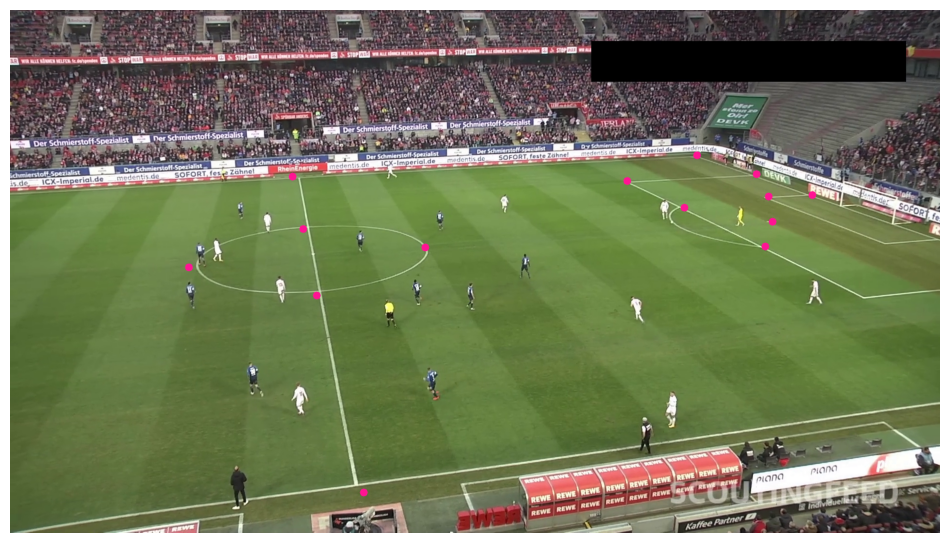

In [15]:
vertex_annotator=sv.VertexAnnotator(
    color=sv.Color.from_hex('#FF1493'),
    radius=8
    
)

# result=model(frame,conf=0.3)[0]
# key_points=sv.KeyPoints.from_ultralytics(result)

result=model.infer(frame,confidence=0.3)[0]
key_points=sv.KeyPoints.from_inference(result)

filter=key_points.confidence[0]>0.5
frame_reference_points=key_points.xy[0][filter]
frame_reference_key_points=sv.KeyPoints(xy=frame_reference_points[np.newaxis,...])

annotated_frame=frame.copy()
annotated_frame=vertex_annotator.annotate(annotated_frame,frame_reference_key_points)


# #if not filtered it will give all predicted points that may or may not be the keypoints based on confidence so we filter points based on more than 50% confidence
sv.plot_image(annotated_frame) #after filtering it will predict the keypoints which we want

# project pitch lines on frame

In [4]:
# we already have points on the source plane as predicted above
# we need points on the target plane so that we can get the homography matrix

# contains coordinates of the 32 points on the 2d pitch described in 'cm' and which vertex is connected to which vetex
from utils.soccer import SoccerPitchConfiguration

CONFIG=SoccerPitchConfiguration()

In [5]:
CONFIG.vertices

[(0, 0),
 (0, 1450.0),
 (0, 2584.0),
 (0, 4416.0),
 (0, 5550.0),
 (0, 7000),
 (550, 2584.0),
 (550, 4416.0),
 (1100, 3500.0),
 (2015, 1450.0),
 (2015, 2584.0),
 (2015, 4416.0),
 (2015, 5550.0),
 (6000.0, 0),
 (6000.0, 2585.0),
 (6000.0, 4415.0),
 (6000.0, 7000),
 (9985, 1450.0),
 (9985, 2584.0),
 (9985, 4416.0),
 (9985, 5550.0),
 (10900, 3500.0),
 (11450, 2584.0),
 (11450, 4416.0),
 (12000, 0),
 (12000, 1450.0),
 (12000, 2584.0),
 (12000, 4416.0),
 (12000, 5550.0),
 (12000, 7000),
 (5085.0, 3500.0),
 (6915.0, 3500.0)]

In [18]:
CONFIG.edges

[(1, 2),
 (2, 3),
 (3, 4),
 (4, 5),
 (5, 6),
 (7, 8),
 (10, 11),
 (11, 12),
 (12, 13),
 (14, 15),
 (15, 16),
 (16, 17),
 (18, 19),
 (19, 20),
 (20, 21),
 (23, 24),
 (25, 26),
 (26, 27),
 (27, 28),
 (28, 29),
 (29, 30),
 (1, 14),
 (2, 10),
 (3, 7),
 (4, 8),
 (5, 13),
 (6, 17),
 (14, 25),
 (18, 26),
 (23, 27),
 (24, 28),
 (21, 29),
 (17, 30)]

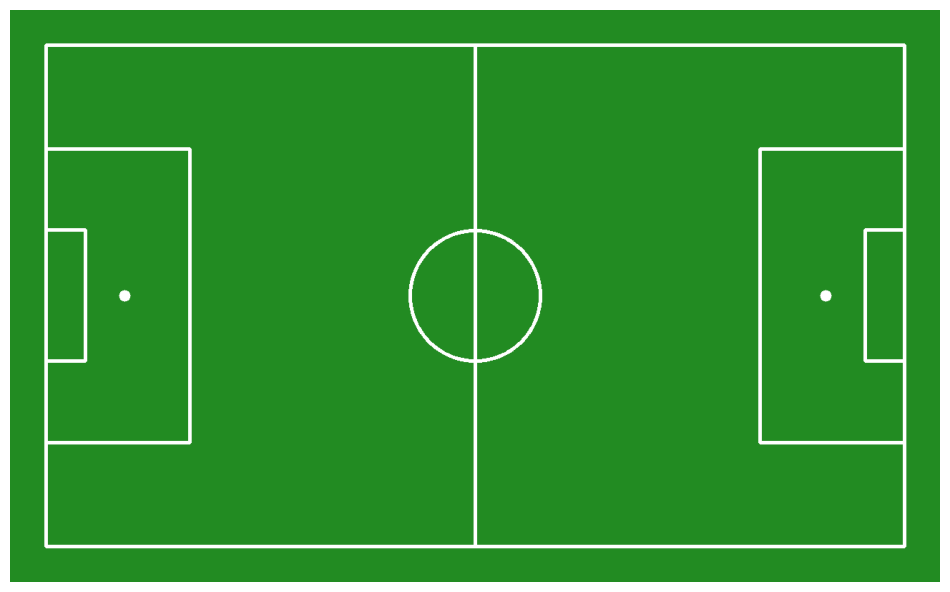

In [19]:
from utils.soccer_annotator import draw_pitch

# show the layout of the pitch based on the configuration we pass
annotated_frame=draw_pitch(CONFIG)

sv.plot_image(annotated_frame)

In [10]:
class ViewTransformer:

    def __init__(self,source: np.ndarray, target: np.ndarray):
        source=source.astype(np.float32)
        target=target.astype(np.float32)

        self.m,_=cv2.findHomography(source,target)

    def transform_points(self,points:np.ndarray)->np.ndarray:
        if points.size == 0:
            return points
            
        reshaped_points=points.reshape(-1,1,2).astype(np.float32) #expand the dimensionality of points from 2d to 3d plane as homography matrix is 3*3 matrix
        points=cv2.perspectiveTransform(reshaped_points,self.m)
        
        return points.reshape(-1,2).astype(np.float32)














## adding transformation to the example

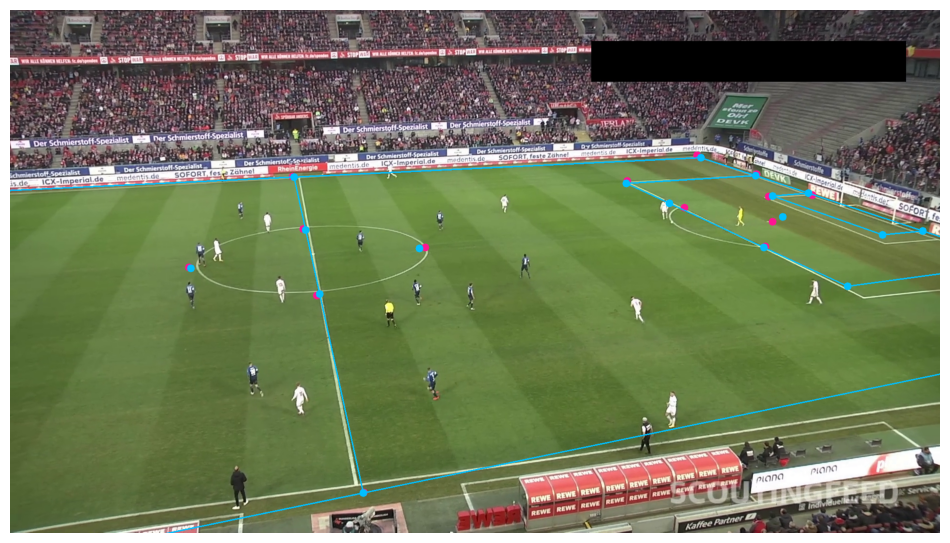

In [21]:
# pink points from the keypoints detection algorithm
vertex_annotator=sv.VertexAnnotator(
    color=sv.Color.from_hex('#FF1493'),
    radius=8
)

# blue points and lines are the projection performed using our view transform
edge_annotator=sv.EdgeAnnotator(
    color=sv.Color.from_hex('#00BFFF'),
    thickness=2,
    edges=CONFIG.edges

)

vertex_annotator_2 = sv.VertexAnnotator(
    color=sv.Color.from_hex('#00BFFF'),
    radius=8)



# model=YOLO(model_path)

# result=model(frame,conf=0.3)[0]
# key_points=sv.KeyPoints.from_ultralytics(result)

filter = key_points.confidence[0] > 0.5 #gives a boolean filter based on indicies of points which one to take and which one to not
frame_reference_points = key_points.xy[0][filter]
frame_reference_key_points = sv.KeyPoints(xy=frame_reference_points[np.newaxis, ...])

pitch_reference_points = np.array(CONFIG.vertices)[filter]

view_tranformer=ViewTransformer(
    source=pitch_reference_points, #the 2d pitch we have
    target=frame_reference_points #the points on the 3d frame which were predicted
)

pitch_all_points=np.array(CONFIG.vertices)  #all key ppints on the pitch
frame_all_points=view_tranformer.transform_points(pitch_all_points)  #recieved the points from homography tranformation of all points from pitch perspective to this image
frame_all_key_points =  sv.KeyPoints(xy=frame_all_points[np.newaxis,...]) 



annotated_frame=frame.copy()
annotated_frame=vertex_annotator.annotate(annotated_frame,frame_reference_key_points)
annotated_frame=edge_annotator.annotate(annotated_frame,frame_all_key_points)
annotated_frame = vertex_annotator_2.annotate(scene=annotated_frame,key_points=frame_all_key_points)


#if not filtered it will give all predicted points that may or may not be the keypoints based on confidence so we filter points based on more than 50% confidence
sv.plot_image(annotated_frame) #after filtering it will predict the keypoints which we want

# Doing the opposite task of projecing from camera perspective to pitch perspective

### The Idea is take the detection that we acquired using object detection model to move them to pitch perspective using our view transformer

In [9]:
def extract_crops(src_video_path:str):
    stride=30
    frame_generator=sv.get_video_frames_generator(src_video_path,stride=stride)
    crops=[]
    Player_id=2
    
    for frame in tqdm(frame_generator, desc='collecting crops', leave=False):
        result= detection_model(frame,conf=0.3)[0]
        detections=sv.Detections.from_ultralytics(result)
        detections=detections.with_nms(threshold=0.5,class_agnostic=True)
        detections=detections[detections.class_id == Player_id]
        crops+=[
            sv.crop_image(frame,xyxy)
            for xyxy 
            in detections.xyxy
        ]

    return crops

def resolve_goalkeepers_team_id(players_detections: sv.Detections, goalkeepers_detections:sv.Detections):
    # using the assumption the midfielder and defense closer to the goalkeeper and thus on average goolkeeper will be closer to its overall mean value
    
    goalkeepers_xy=goalkeepers_detections.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
    players_xy=players_detections.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)


    team_0_centeroid = players_xy[players_detections.class_id==0].mean(axis=0)
    team_1_centeroid = players_xy[players_detections.class_id==1].mean(axis=0)



    goalkeepers_team_ids=[]
    for xy in goalkeepers_xy:
        dist_0=np.linalg.norm(xy-team_0_centeroid)
        dist_1=np.linalg.norm(xy-team_1_centeroid)

        goalkeepers_team_ids.append(0 if dist_0<dist_1 else 1)
        

    return np.array(goalkeepers_team_ids)
    

In [42]:
# training team classifier
crops=extract_crops(src_video_path)
team_classifier=TeamClassifier(device=device)
team_classifier.fit(crops)

collecting crops: 0it [00:00, ?it/s]


0: 736x1280 21 players, 4 referees, 37.4ms
Speed: 31.1ms preprocess, 37.4ms inference, 2.6ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 20 players, 3 referees, 27.9ms
Speed: 18.5ms preprocess, 27.9ms inference, 2.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 ball, 21 players, 3 referees, 39.7ms
Speed: 16.5ms preprocess, 39.7ms inference, 2.5ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 21 players, 3 referees, 54.0ms
Speed: 17.6ms preprocess, 54.0ms inference, 2.6ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 ball, 21 players, 3 referees, 49.0ms
Speed: 21.8ms preprocess, 49.0ms inference, 3.1ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 1 referee, 34.7ms
Speed: 21.3ms preprocess, 34.7ms inference, 2.7ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 ball, 1 goalkeeper, 19 players, 2 referees, 40.3ms
Speed: 17.2ms preprocess, 40.3ms infere

Embedding extraction: 16it [00:03,  4.36it/s]



0: 736x1280 1 goalkeeper, 23 players, 2 referees, 26.2ms
Speed: 8.1ms preprocess, 26.2ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  7.61it/s]


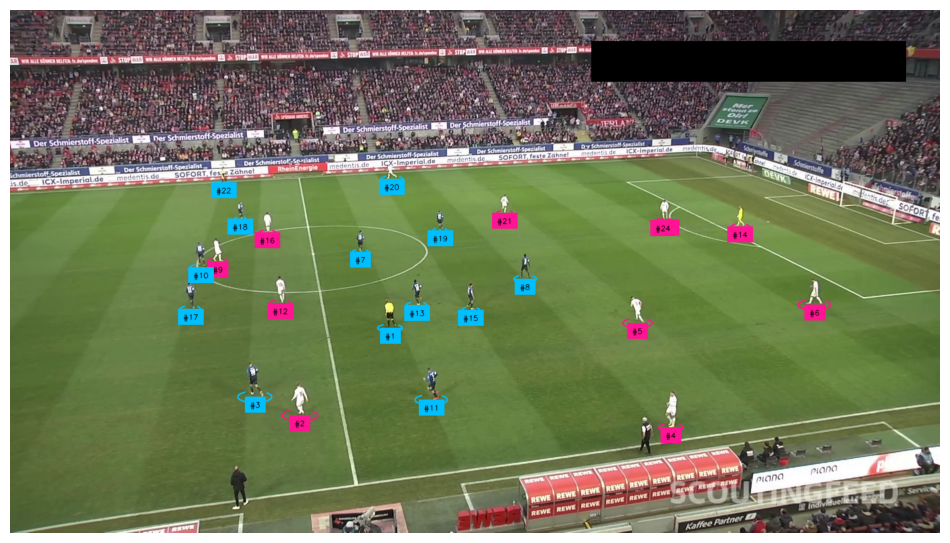


0: 384x640 2 pitchs, 23.9ms
Speed: 2.8ms preprocess, 23.9ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)


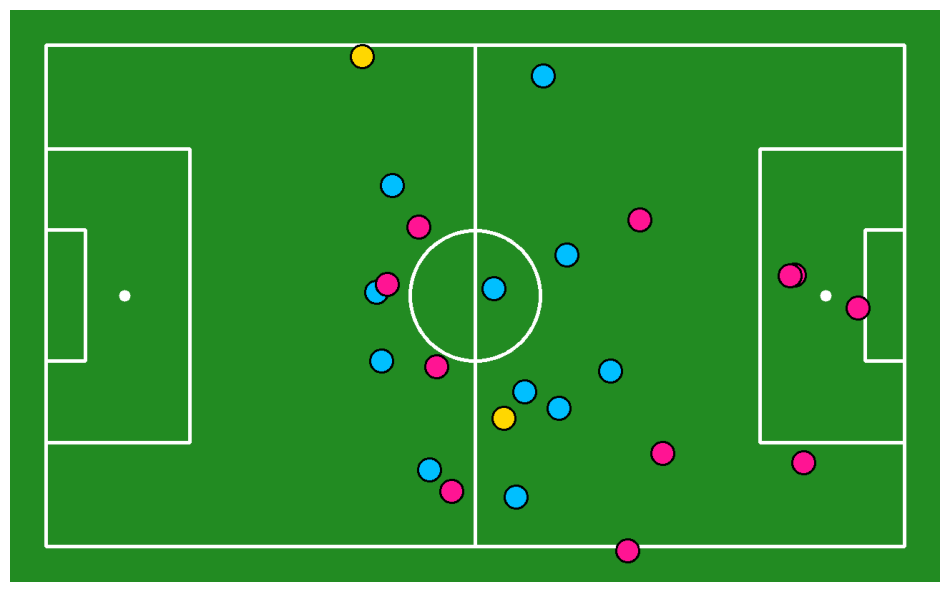

In [58]:
ball_id = 0
goalkeeper_id=1
player_id =  2
referee_id=3

ellipse_annotator = sv.EllipseAnnotator(
    color=sv.ColorPalette.from_hex(['#00BFFF', '#FF1493', '#FFD700']),
    thickness=2
)


label_annotator=sv.LabelAnnotator(
    color=sv.ColorPalette.from_hex(['#00BFFF', '#FF1493', '#FFD700']),
    text_color=sv.Color.from_hex("#000000"),
    text_position=sv.Position.BOTTOM_CENTER

)

triangle_annotator = sv.TriangleAnnotator(
    color=sv.Color.from_hex('#FFD700'),
    base=25,
    height=21,
    outline_thickness=1
)


tracker=sv.ByteTrack()
tracker.reset()

# getting the detections
result = detection_model(frame, conf=0.3)[0]
detections = sv.Detections.from_ultralytics(result)


ball_detections = detections[detections.class_id == ball_id]
ball_detections.xyxy = sv.pad_boxes(xyxy=ball_detections.xyxy, px=10)

# # detections except ball
all_detections = detections[detections.class_id != ball_id]
all_detections = all_detections.with_nms(threshold=0.5, class_agnostic=True)
all_detections=tracker.update_with_detections(all_detections)

# getting the players from detections
players_detections=all_detections[all_detections.class_id==player_id]
goalkeepers_detections=all_detections[all_detections.class_id==goalkeeper_id]
referees_detections=all_detections[all_detections.class_id==referee_id]

players_crops=[sv.crop_image(frame,xyxy) for xyxy in players_detections.xyxy] # cropping each player detections in image
players_detections.class_id=team_classifier.predict(players_crops)
goalkeepers_detections.class_id=resolve_goalkeepers_team_id(players_detections,goalkeepers_detections)

all_detections = sv.Detections.merge([
    players_detections, goalkeepers_detections, referees_detections
])


# frame visualization

labels = [
    f"#{tracker_id}"
    for tracker_id
    in all_detections.tracker_id
]

all_detections.class_id = all_detections.class_id.astype(int)

annotated_frame = frame.copy()
annotated_frame = ellipse_annotator.annotate(
    scene=annotated_frame,
    detections=all_detections)
annotated_frame = label_annotator.annotate(
    scene=annotated_frame,
    detections=all_detections,
    labels=labels)
annotated_frame = triangle_annotator.annotate(
    scene=annotated_frame,
    detections=ball_detections)

sv.plot_image(annotated_frame)



players_detections = sv.Detections.merge([
    players_detections, goalkeepers_detections
])



# # code for keypoint detection


result=model(frame,conf=0.3)[0]
key_points=sv.KeyPoints.from_ultralytics(result)

# result=model.infer(frame,confidence=0.3)[0]
# key_points=sv.KeyPoints.from_inference(result)



filter=key_points.confidence[0]>0.5  #gives a boolean filter based on indicies of points which one to take and which one to not
frame_reference_points=key_points.xy[0][filter]
frame_reference_key_points=sv.KeyPoints(xy=frame_reference_points[np.newaxis,...])
pitch_reference_points = np.array(CONFIG.vertices)[filter]


# as now we want point to be projected from camera perspective to pitch perspective
view_tranformer=ViewTransformer(
    source=frame_reference_points,#the points on the 3d frame which were predicted
    target=pitch_reference_points #the 2d pitch we have
)


# for ball
frame_ball_xy = ball_detections.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
pitch_ball_xy = view_tranformer.transform_points(frame_ball_xy)   #going from camera frame to pitch_frame


# for player
frame_players_xy = players_detections.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
pitch_players_xy = view_tranformer.transform_points(frame_players_xy)  

# for referees
frame_referees_xy = referees_detections.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
pitch_referees_xy = view_tranformer.transform_points(frame_referees_xy)  


annotated_frame=draw_pitch(config=CONFIG) #gets the entire layout

annotated_frame = draw_points_on_pitch( 
        config=CONFIG,
        xy=pitch_ball_xy,
        face_color=sv.Color.WHITE,
        edge_color=sv.Color.BLACK,
        radius=10,
        pitch=annotated_frame

    )


annotated_frame = draw_points_on_pitch( 
        config=CONFIG,
        xy=pitch_players_xy[players_detections.class_id == 0],
        face_color=sv.Color.from_hex("00BFFF"),
        edge_color=sv.Color.BLACK,
        radius=16,
        pitch=annotated_frame
    )

annotated_frame = draw_points_on_pitch(
        config=CONFIG,
        xy=pitch_players_xy[players_detections.class_id==1],
        face_color=sv.Color.from_hex("FF1493"),
        edge_color=sv.Color.BLACK,
        radius=16,
        pitch=annotated_frame

    )

pitch = draw_points_on_pitch(
        config=CONFIG,
        xy=pitch_referees_xy,
        face_color=sv.Color.from_hex("FFD700"),
        edge_color=sv.Color.BLACK,
        radius=16,
        pitch=annotated_frame
)


sv.plot_image(annotated_frame)

# Complete Pipeline for Video

In [2]:
import cv2

# Input and output video paths
src_video_path = 'dataset/tests/2e57b9_0.mp4'
output_video_path = 'dataset/tests/2e57b9_0_reduced.mp4'

# Open the video file
cap = cv2.VideoCapture(src_video_path)
fps = int(cap.get(cv2.CAP_PROP_FPS))
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

# Define video writer
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(output_video_path, fourcc, fps, (width, height))

# Read and write first 100 frames
for i in range(100):
    ret, frame = cap.read()
    if not ret:  # Stop if video ends before 100 frames
        break
    out.write(frame)

cap.release()
out.release()
print(f"First 100 frames saved to: {output_video_path}")

First 100 frames saved to: dataset/tests/2e57b9_0_reduced.mp4


In [21]:
src_video_path='dataset/tests/2e57b9_0.mp4'
# src_video_path=output_video_path
# video_info=sv.VideoInfo.from_video_path(src_video_path)
target_video_path='dataset/tests/2e57b9_0_result_players.mp4'
target_video_path_2='dataset/tests/2e57b9_0_result_pitch.mp4'


ball_id = 0
goalkeeper_id=1
player_id =  2
referee_id=3

# for ellipse and label the first 2 are for the players for two teams respectively and the last color is for referee
ellipse_annotator = sv.EllipseAnnotator(
    color=sv.ColorPalette.from_hex(['#00BFFF', '#FF1493', '#FFD700']), 
    thickness=2
)

label_annotator=sv.LabelAnnotator(
    color=sv.ColorPalette.from_hex(['#00BFFF', '#FF1493', '#FFD700']),
    text_color=sv.Color.from_hex("#000000"),
    text_position=sv.Position.BOTTOM_CENTER

)

triangle_annotator = sv.TriangleAnnotator(
    color=sv.Color.from_hex('#FFD700'),
    base=25,
    height=21,
)


# training the team classifier
crops=extract_crops(src_video_path)
team_classifier=TeamClassifier(device=device)
team_classifier.fit(crops)


tracker=sv.ByteTrack()
tracker.reset()

# getting the frame
video_info=sv.VideoInfo.from_video_path(src_video_path)
video_sink=sv.VideoSink(target_video_path,video_info=video_info)
video_sink_2=sv.VideoSink(target_video_path_2,video_info=video_info)
frame_generator=sv.get_video_frames_generator(src_video_path)


target_height = video_info.height
target_width = video_info.width


detection_model = detection_model.to(device)


with video_sink,video_sink_2:
    for i,frame in enumerate(tqdm(frame_generator,total=video_info.total_frames)):
    
        # frame=frame.to(device)

        frame_tensor = torch.from_numpy(frame).to(device)


        frame_tensor = frame_tensor.float() / 255.0  # Normalize if model expects values in [0,1]
        frame_tensor = frame_tensor.permute(2, 0, 1)  #
        
        # getting the detections
        result = detection_model(frame, conf=0.3)[0]
        detections = sv.Detections.from_ultralytics(result)
        
        
        ball_detections = detections[detections.class_id == ball_id]
        ball_detections.xyxy = sv.pad_boxes(xyxy=ball_detections.xyxy, px=10)
        
        # detections except ball
        all_detections = detections[detections.class_id != ball_id]
        all_detections = all_detections.with_nms(threshold=0.5, class_agnostic=True)
        all_detections=tracker.update_with_detections(all_detections)
        
        # getting the players from detections
        players_detections=all_detections[all_detections.class_id==player_id]
        goalkeepers_detections=all_detections[all_detections.class_id==goalkeeper_id]
        referees_detections=all_detections[all_detections.class_id==referee_id]
        
        players_crops=[sv.crop_image(frame,xyxy) for xyxy in players_detections.xyxy] # cropping each player detections in image
        players_detections.class_id=team_classifier.predict(players_crops)
        goalkeepers_detections.class_id=resolve_goalkeepers_team_id(players_detections,goalkeepers_detections)

        referees_detections.class_id-=1


        all_detections=sv.Detections.merge([players_detections,goalkeepers_detections,referees_detections])


        labels = [f"#{tracker_id}"  for tracker_id in all_detections.tracker_id]



        all_detections.class_id = all_detections.class_id.astype(int)


        annotated_frame = frame.copy()
        annotated_frame = ellipse_annotator.annotate(scene=annotated_frame,detections=all_detections)
        annotated_frame = triangle_annotator.annotate(scene=annotated_frame,detections=ball_detections)
        annotated_frame= label_annotator.annotate(scene=annotated_frame,detections=all_detections,labels=labels)

        video_sink.write_frame(annotated_frame)



        players_detections = sv.Detections.merge([players_detections, goalkeepers_detections])

        # result=model(frame,conf=0.3)[0]
        # key_points=sv.KeyPoints.from_ultralytics(result)

        result=model.infer(frame,confidence=0.3)[0]
        key_points=sv.KeyPoints.from_inference(result)


        filter=key_points.confidence[0]>0.5  #gives a boolean filter based on indicies of points which one to take and which one to not
        frame_reference_points=key_points.xy[0][filter]
        frame_reference_key_points=sv.KeyPoints(xy=frame_reference_points[np.newaxis,...])
        pitch_reference_points = np.array(CONFIG.vertices)[filter]


        # as now we want point to be projected from camera perspective to pitch perspective
        view_tranformer=ViewTransformer(
        source=frame_reference_points,#the points on the 3d frame which were predicted
        target=pitch_reference_points #the 2d pitch we have
        )


        # for ball
        frame_ball_xy = ball_detections.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
        pitch_ball_xy = view_tranformer.transform_points(frame_ball_xy)   #going from camera frame to pitch_frame


        # for player
        frame_players_xy = players_detections.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
        pitch_players_xy = view_tranformer.transform_points(frame_players_xy)  


        # for referees
        frame_referees_xy = referees_detections.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
        pitch_referees_xy = view_tranformer.transform_points(frame_referees_xy)  


        annotated_frame=draw_pitch(config=CONFIG)


        annotated_frame = draw_points_on_pitch( 
        config=CONFIG,
        xy=pitch_ball_xy,
        face_color=sv.Color.WHITE,
        edge_color=sv.Color.BLACK,
        radius=10,
        pitch=annotated_frame

        )

        annotated_frame = draw_points_on_pitch( 
                config=CONFIG,
                xy=pitch_players_xy[players_detections.class_id == 0],
                face_color=sv.Color.from_hex("00BFFF"),
                edge_color=sv.Color.BLACK,
                radius=16,
                pitch=annotated_frame
            )
        
        annotated_frame = draw_points_on_pitch(
                config=CONFIG,
                xy=pitch_players_xy[players_detections.class_id==1],
                face_color=sv.Color.from_hex("FF1493"),
                edge_color=sv.Color.BLACK,
                radius=16,
                pitch=annotated_frame
        
            )
        
        pitch = draw_points_on_pitch(
                config=CONFIG,
                xy=pitch_referees_xy,
                face_color=sv.Color.from_hex("FFD700"),
                edge_color=sv.Color.BLACK,
                radius=16,
                pitch=annotated_frame
        )


        resized_annotated_frame = cv2.resize(annotated_frame, (target_width, target_height))
        # resized_annotated_frame = cv2.cvtColor(resized_annotated_frame, cv2.COLOR_BGR2RGB)
        video_sink_2.write_frame(frame=resized_annotated_frame)

        print(f"done for {i}th frame")




    

collecting crops: 0it [00:00, ?it/s]


0: 736x1280 21 players, 4 referees, 43.6ms
Speed: 12.1ms preprocess, 43.6ms inference, 2.4ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 20 players, 3 referees, 30.4ms
Speed: 7.4ms preprocess, 30.4ms inference, 2.1ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 ball, 21 players, 3 referees, 60.0ms
Speed: 14.7ms preprocess, 60.0ms inference, 12.7ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 21 players, 3 referees, 61.5ms
Speed: 10.2ms preprocess, 61.5ms inference, 12.6ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 ball, 21 players, 3 referees, 61.4ms
Speed: 7.6ms preprocess, 61.4ms inference, 12.8ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 1 referee, 33.8ms
Speed: 7.9ms preprocess, 33.8ms inference, 6.5ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 ball, 1 goalkeeper, 19 players, 2 referees, 67.8ms
Speed: 12.4ms preprocess, 67.8ms infere

Embedding extraction: 16it [00:04,  3.55it/s]


  0%|          | 0/750 [00:00<?, ?it/s]


0: 736x1280 21 players, 4 referees, 31.7ms
Speed: 11.3ms preprocess, 31.7ms inference, 2.5ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  6.93it/s]


done for 0th frame

0: 736x1280 1 goalkeeper, 21 players, 4 referees, 43.9ms
Speed: 11.7ms preprocess, 43.9ms inference, 3.1ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  6.23it/s]


done for 1th frame

0: 736x1280 21 players, 3 referees, 28.7ms
Speed: 13.8ms preprocess, 28.7ms inference, 2.4ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  6.64it/s]


done for 2th frame

0: 736x1280 1 goalkeeper, 22 players, 3 referees, 30.9ms
Speed: 9.2ms preprocess, 30.9ms inference, 4.2ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  4.66it/s]


done for 3th frame

0: 736x1280 1 goalkeeper, 21 players, 3 referees, 56.4ms
Speed: 11.3ms preprocess, 56.4ms inference, 4.2ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  4.54it/s]


done for 4th frame

0: 736x1280 21 players, 3 referees, 60.6ms
Speed: 14.9ms preprocess, 60.6ms inference, 6.1ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  3.84it/s]


done for 5th frame

0: 736x1280 1 ball, 21 players, 4 referees, 63.2ms
Speed: 11.0ms preprocess, 63.2ms inference, 18.2ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  5.30it/s]


done for 6th frame

0: 736x1280 21 players, 3 referees, 60.6ms
Speed: 9.5ms preprocess, 60.6ms inference, 13.2ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  5.06it/s]


done for 7th frame

0: 736x1280 1 ball, 1 goalkeeper, 21 players, 3 referees, 58.0ms
Speed: 11.0ms preprocess, 58.0ms inference, 12.2ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  5.31it/s]


done for 8th frame

0: 736x1280 1 ball, 1 goalkeeper, 21 players, 3 referees, 59.5ms
Speed: 13.6ms preprocess, 59.5ms inference, 12.0ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  3.95it/s]


done for 9th frame

0: 736x1280 1 ball, 21 players, 3 referees, 58.8ms
Speed: 11.3ms preprocess, 58.8ms inference, 11.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  5.20it/s]


done for 10th frame

0: 736x1280 1 ball, 1 goalkeeper, 21 players, 3 referees, 37.5ms
Speed: 11.5ms preprocess, 37.5ms inference, 3.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  4.49it/s]


done for 11th frame

0: 736x1280 1 ball, 1 goalkeeper, 21 players, 5 referees, 64.1ms
Speed: 10.6ms preprocess, 64.1ms inference, 6.2ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  3.68it/s]


done for 12th frame

0: 736x1280 1 ball, 1 goalkeeper, 21 players, 4 referees, 59.1ms
Speed: 10.9ms preprocess, 59.1ms inference, 16.5ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  3.81it/s]


done for 13th frame

0: 736x1280 1 ball, 1 goalkeeper, 21 players, 3 referees, 59.5ms
Speed: 11.5ms preprocess, 59.5ms inference, 12.4ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  5.52it/s]


done for 14th frame

0: 736x1280 21 players, 3 referees, 31.4ms
Speed: 7.4ms preprocess, 31.4ms inference, 2.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  7.74it/s]


done for 15th frame

0: 736x1280 1 ball, 21 players, 3 referees, 28.5ms
Speed: 9.3ms preprocess, 28.5ms inference, 2.4ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  6.34it/s]


done for 16th frame

0: 736x1280 1 ball, 21 players, 3 referees, 28.9ms
Speed: 9.1ms preprocess, 28.9ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  7.89it/s]


done for 17th frame

0: 736x1280 1 ball, 21 players, 3 referees, 48.3ms
Speed: 16.3ms preprocess, 48.3ms inference, 4.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  5.05it/s]


done for 18th frame

0: 736x1280 1 ball, 21 players, 3 referees, 29.2ms
Speed: 10.3ms preprocess, 29.2ms inference, 2.0ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  6.49it/s]


done for 19th frame

0: 736x1280 1 ball, 21 players, 3 referees, 38.2ms
Speed: 12.4ms preprocess, 38.2ms inference, 4.5ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  5.71it/s]


done for 20th frame

0: 736x1280 1 ball, 21 players, 3 referees, 28.7ms
Speed: 10.6ms preprocess, 28.7ms inference, 3.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  3.74it/s]


done for 21th frame

0: 736x1280 1 ball, 21 players, 3 referees, 47.2ms
Speed: 13.3ms preprocess, 47.2ms inference, 2.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  4.54it/s]


done for 22th frame

0: 736x1280 1 ball, 21 players, 3 referees, 58.3ms
Speed: 9.4ms preprocess, 58.3ms inference, 12.0ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  5.84it/s]


done for 23th frame

0: 736x1280 21 players, 3 referees, 58.4ms
Speed: 9.4ms preprocess, 58.4ms inference, 12.1ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  5.04it/s]


done for 24th frame

0: 736x1280 21 players, 3 referees, 58.9ms
Speed: 9.4ms preprocess, 58.9ms inference, 12.2ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  5.09it/s]


done for 25th frame

0: 736x1280 21 players, 3 referees, 35.6ms
Speed: 14.8ms preprocess, 35.6ms inference, 6.4ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  3.91it/s]


done for 26th frame

0: 736x1280 21 players, 3 referees, 59.8ms
Speed: 10.9ms preprocess, 59.8ms inference, 12.1ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  4.40it/s]


done for 27th frame

0: 736x1280 21 players, 3 referees, 63.0ms
Speed: 15.3ms preprocess, 63.0ms inference, 13.4ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  4.83it/s]


done for 28th frame

0: 736x1280 21 players, 3 referees, 59.3ms
Speed: 13.8ms preprocess, 59.3ms inference, 21.9ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  3.44it/s]


done for 29th frame

0: 736x1280 20 players, 3 referees, 59.2ms
Speed: 15.0ms preprocess, 59.2ms inference, 12.2ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  3.16it/s]


done for 30th frame

0: 736x1280 21 players, 3 referees, 58.4ms
Speed: 9.4ms preprocess, 58.4ms inference, 12.3ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  5.81it/s]


done for 31th frame

0: 736x1280 21 players, 3 referees, 62.3ms
Speed: 10.2ms preprocess, 62.3ms inference, 12.2ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  7.98it/s]


done for 32th frame

0: 736x1280 21 players, 3 referees, 32.5ms
Speed: 9.6ms preprocess, 32.5ms inference, 2.1ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  6.47it/s]


done for 33th frame

0: 736x1280 20 players, 4 referees, 47.6ms
Speed: 11.2ms preprocess, 47.6ms inference, 8.6ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  6.85it/s]


done for 34th frame

0: 736x1280 20 players, 3 referees, 46.1ms
Speed: 20.7ms preprocess, 46.1ms inference, 3.3ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  5.56it/s]


done for 35th frame

0: 736x1280 20 players, 4 referees, 38.9ms
Speed: 10.3ms preprocess, 38.9ms inference, 4.3ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  6.26it/s]


done for 36th frame

0: 736x1280 21 players, 2 referees, 38.3ms
Speed: 12.7ms preprocess, 38.3ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  4.96it/s]


done for 37th frame

0: 736x1280 22 players, 2 referees, 33.8ms
Speed: 11.2ms preprocess, 33.8ms inference, 3.3ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  4.10it/s]


done for 38th frame

0: 736x1280 1 goalkeeper, 22 players, 2 referees, 50.2ms
Speed: 10.5ms preprocess, 50.2ms inference, 6.0ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  3.40it/s]


done for 39th frame

0: 736x1280 1 goalkeeper, 21 players, 2 referees, 81.6ms
Speed: 34.9ms preprocess, 81.6ms inference, 11.9ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  5.84it/s]


done for 40th frame

0: 736x1280 1 goalkeeper, 21 players, 4 referees, 57.8ms
Speed: 10.6ms preprocess, 57.8ms inference, 11.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  6.63it/s]


done for 41th frame

0: 736x1280 1 ball, 21 players, 3 referees, 56.9ms
Speed: 9.7ms preprocess, 56.9ms inference, 11.6ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  5.51it/s]


done for 42th frame

0: 736x1280 1 ball, 21 players, 3 referees, 29.9ms
Speed: 9.0ms preprocess, 29.9ms inference, 2.5ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  4.74it/s]


done for 43th frame

0: 736x1280 1 ball, 22 players, 4 referees, 58.5ms
Speed: 15.8ms preprocess, 58.5ms inference, 11.9ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  4.29it/s]


done for 44th frame

0: 736x1280 1 ball, 21 players, 3 referees, 58.3ms
Speed: 10.8ms preprocess, 58.3ms inference, 11.3ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  5.17it/s]


done for 45th frame

0: 736x1280 1 ball, 22 players, 4 referees, 55.3ms
Speed: 12.9ms preprocess, 55.3ms inference, 12.1ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  4.42it/s]


done for 46th frame

0: 736x1280 1 ball, 21 players, 4 referees, 58.6ms
Speed: 12.0ms preprocess, 58.6ms inference, 13.5ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  5.46it/s]


done for 47th frame

0: 736x1280 1 ball, 21 players, 3 referees, 49.7ms
Speed: 11.8ms preprocess, 49.7ms inference, 5.1ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  4.15it/s]


done for 48th frame

0: 736x1280 21 players, 3 referees, 25.3ms
Speed: 9.0ms preprocess, 25.3ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  9.12it/s]


done for 49th frame

0: 736x1280 21 players, 3 referees, 24.9ms
Speed: 9.1ms preprocess, 24.9ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  9.17it/s]


done for 50th frame

0: 736x1280 22 players, 3 referees, 24.9ms
Speed: 20.9ms preprocess, 24.9ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  6.69it/s]


done for 51th frame

0: 736x1280 1 ball, 21 players, 3 referees, 25.2ms
Speed: 9.0ms preprocess, 25.2ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  8.11it/s]


done for 52th frame

0: 736x1280 1 ball, 21 players, 3 referees, 25.3ms
Speed: 10.0ms preprocess, 25.3ms inference, 2.9ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  4.97it/s]


done for 53th frame

0: 736x1280 21 players, 4 referees, 38.5ms
Speed: 10.2ms preprocess, 38.5ms inference, 2.0ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  7.71it/s]


done for 54th frame

0: 736x1280 21 players, 3 referees, 34.9ms
Speed: 22.9ms preprocess, 34.9ms inference, 2.5ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  4.75it/s]


done for 55th frame

0: 736x1280 1 ball, 21 players, 3 referees, 90.0ms
Speed: 20.5ms preprocess, 90.0ms inference, 6.5ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  3.19it/s]


done for 56th frame

0: 736x1280 21 players, 3 referees, 41.3ms
Speed: 14.6ms preprocess, 41.3ms inference, 3.2ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  3.90it/s]


done for 57th frame

0: 736x1280 21 players, 3 referees, 57.0ms
Speed: 10.3ms preprocess, 57.0ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  6.15it/s]


done for 58th frame

0: 736x1280 1 ball, 21 players, 2 referees, 57.8ms
Speed: 10.8ms preprocess, 57.8ms inference, 11.6ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  5.60it/s]


done for 59th frame

0: 736x1280 1 ball, 21 players, 3 referees, 57.9ms
Speed: 9.9ms preprocess, 57.9ms inference, 11.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  5.38it/s]


done for 60th frame

0: 736x1280 1 ball, 21 players, 3 referees, 58.1ms
Speed: 15.0ms preprocess, 58.1ms inference, 11.4ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  4.59it/s]


done for 61th frame

0: 736x1280 1 ball, 21 players, 3 referees, 51.0ms
Speed: 17.0ms preprocess, 51.0ms inference, 12.0ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  4.28it/s]


done for 62th frame

0: 736x1280 2 balls, 21 players, 3 referees, 28.7ms
Speed: 11.0ms preprocess, 28.7ms inference, 3.9ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  4.67it/s]


done for 63th frame

0: 736x1280 2 balls, 21 players, 3 referees, 29.5ms
Speed: 11.6ms preprocess, 29.5ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  8.04it/s]


done for 64th frame

0: 736x1280 2 balls, 21 players, 3 referees, 25.1ms
Speed: 11.4ms preprocess, 25.1ms inference, 3.1ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  3.16it/s]


done for 65th frame

0: 736x1280 2 balls, 21 players, 3 referees, 55.5ms
Speed: 14.1ms preprocess, 55.5ms inference, 3.5ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  5.00it/s]


done for 66th frame

0: 736x1280 1 ball, 21 players, 2 referees, 25.3ms
Speed: 9.0ms preprocess, 25.3ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  9.33it/s]


done for 67th frame

0: 736x1280 1 ball, 21 players, 2 referees, 25.3ms
Speed: 8.9ms preprocess, 25.3ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  9.47it/s]


done for 68th frame

0: 736x1280 1 ball, 21 players, 1 referee, 25.3ms
Speed: 9.9ms preprocess, 25.3ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  8.07it/s]


done for 69th frame

0: 736x1280 1 ball, 21 players, 1 referee, 25.3ms
Speed: 9.2ms preprocess, 25.3ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  8.31it/s]


done for 70th frame

0: 736x1280 1 ball, 21 players, 2 referees, 46.9ms
Speed: 14.0ms preprocess, 46.9ms inference, 2.0ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  4.15it/s]


done for 71th frame

0: 736x1280 1 ball, 21 players, 2 referees, 57.5ms
Speed: 10.4ms preprocess, 57.5ms inference, 11.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  5.07it/s]


done for 72th frame

0: 736x1280 1 ball, 22 players, 2 referees, 57.4ms
Speed: 12.1ms preprocess, 57.4ms inference, 11.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  3.69it/s]


done for 73th frame

0: 736x1280 1 ball, 22 players, 2 referees, 59.1ms
Speed: 15.0ms preprocess, 59.1ms inference, 15.1ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  4.00it/s]


done for 74th frame

0: 736x1280 1 ball, 21 players, 3 referees, 46.1ms
Speed: 11.8ms preprocess, 46.1ms inference, 3.2ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  3.45it/s]


done for 75th frame

0: 736x1280 1 ball, 22 players, 2 referees, 56.5ms
Speed: 9.5ms preprocess, 56.5ms inference, 11.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  5.74it/s]


done for 76th frame

0: 736x1280 1 ball, 21 players, 2 referees, 57.4ms
Speed: 10.8ms preprocess, 57.4ms inference, 11.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  5.80it/s]


done for 77th frame

0: 736x1280 1 ball, 22 players, 3 referees, 57.8ms
Speed: 10.5ms preprocess, 57.8ms inference, 11.9ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  5.35it/s]


done for 78th frame

0: 736x1280 1 ball, 21 players, 2 referees, 35.3ms
Speed: 12.0ms preprocess, 35.3ms inference, 11.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  4.37it/s]


done for 79th frame

0: 736x1280 1 ball, 22 players, 2 referees, 37.6ms
Speed: 11.1ms preprocess, 37.6ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  6.69it/s]


done for 80th frame

0: 736x1280 1 ball, 23 players, 2 referees, 43.3ms
Speed: 15.3ms preprocess, 43.3ms inference, 3.6ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  4.55it/s]


done for 81th frame

0: 736x1280 1 ball, 21 players, 2 referees, 25.2ms
Speed: 9.9ms preprocess, 25.2ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  3.82it/s]


done for 82th frame

0: 736x1280 21 players, 3 referees, 48.6ms
Speed: 10.9ms preprocess, 48.6ms inference, 3.9ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  3.23it/s]


done for 83th frame

0: 736x1280 22 players, 2 referees, 25.2ms
Speed: 8.9ms preprocess, 25.2ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  9.65it/s]


done for 84th frame

0: 736x1280 20 players, 1 referee, 25.2ms
Speed: 8.9ms preprocess, 25.2ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  8.30it/s]


done for 85th frame

0: 736x1280 20 players, 2 referees, 25.2ms
Speed: 9.1ms preprocess, 25.2ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  9.12it/s]


done for 86th frame

0: 736x1280 20 players, 3 referees, 25.3ms
Speed: 9.0ms preprocess, 25.3ms inference, 2.5ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  8.14it/s]


done for 87th frame

0: 736x1280 20 players, 3 referees, 25.3ms
Speed: 10.0ms preprocess, 25.3ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  5.71it/s]


done for 88th frame

0: 736x1280 22 players, 3 referees, 57.9ms
Speed: 18.4ms preprocess, 57.9ms inference, 13.6ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  5.39it/s]


done for 89th frame

0: 736x1280 21 players, 3 referees, 48.4ms
Speed: 10.8ms preprocess, 48.4ms inference, 3.5ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  4.65it/s]


done for 90th frame

0: 736x1280 21 players, 2 referees, 44.2ms
Speed: 9.8ms preprocess, 44.2ms inference, 13.2ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  5.33it/s]


done for 91th frame

0: 736x1280 22 players, 2 referees, 58.3ms
Speed: 9.8ms preprocess, 58.3ms inference, 11.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  3.56it/s]


done for 92th frame

0: 736x1280 21 players, 2 referees, 58.4ms
Speed: 13.2ms preprocess, 58.4ms inference, 11.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  2.85it/s]


done for 93th frame

0: 736x1280 22 players, 2 referees, 58.0ms
Speed: 10.8ms preprocess, 58.0ms inference, 11.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  5.74it/s]


done for 94th frame

0: 736x1280 21 players, 2 referees, 57.4ms
Speed: 10.1ms preprocess, 57.4ms inference, 11.6ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  6.45it/s]


done for 95th frame

0: 736x1280 21 players, 2 referees, 28.4ms
Speed: 9.1ms preprocess, 28.4ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  7.67it/s]


done for 96th frame

0: 736x1280 22 players, 2 referees, 25.2ms
Speed: 9.0ms preprocess, 25.2ms inference, 5.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  7.89it/s]


done for 97th frame

0: 736x1280 21 players, 2 referees, 58.9ms
Speed: 24.4ms preprocess, 58.9ms inference, 4.2ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  5.07it/s]


done for 98th frame

0: 736x1280 22 players, 2 referees, 25.3ms
Speed: 10.2ms preprocess, 25.3ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  7.35it/s]


done for 99th frame

0: 736x1280 21 players, 2 referees, 41.7ms
Speed: 13.3ms preprocess, 41.7ms inference, 3.2ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  5.62it/s]


done for 100th frame

0: 736x1280 22 players, 3 referees, 47.3ms
Speed: 8.8ms preprocess, 47.3ms inference, 4.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  3.23it/s]


done for 101th frame

0: 736x1280 21 players, 3 referees, 60.6ms
Speed: 21.3ms preprocess, 60.6ms inference, 4.9ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  3.92it/s]


done for 102th frame

0: 736x1280 1 ball, 21 players, 2 referees, 25.3ms
Speed: 9.4ms preprocess, 25.3ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  9.18it/s]


done for 103th frame

0: 736x1280 21 players, 3 referees, 57.0ms
Speed: 12.9ms preprocess, 57.0ms inference, 11.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  5.69it/s]


done for 104th frame

0: 736x1280 21 players, 3 referees, 57.0ms
Speed: 12.9ms preprocess, 57.0ms inference, 11.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  6.47it/s]


done for 105th frame

0: 736x1280 21 players, 2 referees, 58.2ms
Speed: 10.4ms preprocess, 58.2ms inference, 11.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  4.83it/s]


done for 106th frame

0: 736x1280 1 ball, 21 players, 3 referees, 57.8ms
Speed: 12.9ms preprocess, 57.8ms inference, 11.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  4.69it/s]


done for 107th frame

0: 736x1280 1 ball, 22 players, 3 referees, 50.1ms
Speed: 12.8ms preprocess, 50.1ms inference, 4.2ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  4.25it/s]


done for 108th frame

0: 736x1280 22 players, 3 referees, 34.1ms
Speed: 10.2ms preprocess, 34.1ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  4.75it/s]


done for 109th frame

0: 736x1280 21 players, 3 referees, 58.4ms
Speed: 13.6ms preprocess, 58.4ms inference, 14.0ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  3.24it/s]


done for 110th frame

0: 736x1280 22 players, 2 referees, 28.2ms
Speed: 8.9ms preprocess, 28.2ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  8.60it/s]


done for 111th frame

0: 736x1280 1 ball, 21 players, 3 referees, 25.0ms
Speed: 9.0ms preprocess, 25.0ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  9.06it/s]


done for 112th frame

0: 736x1280 21 players, 3 referees, 25.0ms
Speed: 7.5ms preprocess, 25.0ms inference, 3.5ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  7.08it/s]


done for 113th frame

0: 736x1280 1 ball, 21 players, 3 referees, 25.3ms
Speed: 9.3ms preprocess, 25.3ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  8.33it/s]


done for 114th frame

0: 736x1280 1 ball, 21 players, 3 referees, 25.3ms
Speed: 9.3ms preprocess, 25.3ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  6.95it/s]


done for 115th frame

0: 736x1280 1 ball, 21 players, 3 referees, 45.0ms
Speed: 10.9ms preprocess, 45.0ms inference, 2.3ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  4.81it/s]


done for 116th frame

0: 736x1280 21 players, 3 referees, 29.1ms
Speed: 9.8ms preprocess, 29.1ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  7.04it/s]


done for 117th frame

0: 736x1280 1 ball, 21 players, 2 referees, 31.6ms
Speed: 12.1ms preprocess, 31.6ms inference, 2.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  4.60it/s]


done for 118th frame

0: 736x1280 1 ball, 21 players, 3 referees, 26.5ms
Speed: 8.8ms preprocess, 26.5ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  6.60it/s]


done for 119th frame

0: 736x1280 1 ball, 21 players, 3 referees, 65.8ms
Speed: 12.1ms preprocess, 65.8ms inference, 16.5ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  3.60it/s]


done for 120th frame

0: 736x1280 1 ball, 21 players, 3 referees, 58.3ms
Speed: 13.7ms preprocess, 58.3ms inference, 17.6ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  4.62it/s]


done for 121th frame

0: 736x1280 1 ball, 1 goalkeeper, 21 players, 3 referees, 57.3ms
Speed: 10.8ms preprocess, 57.3ms inference, 11.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  5.90it/s]


done for 122th frame

0: 736x1280 1 ball, 1 goalkeeper, 21 players, 3 referees, 28.9ms
Speed: 9.1ms preprocess, 28.9ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  5.50it/s]


done for 123th frame

0: 736x1280 1 ball, 21 players, 3 referees, 57.8ms
Speed: 10.6ms preprocess, 57.8ms inference, 7.4ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  5.43it/s]


done for 124th frame

0: 736x1280 1 ball, 21 players, 3 referees, 59.2ms
Speed: 10.8ms preprocess, 59.2ms inference, 11.6ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  4.37it/s]


done for 125th frame

0: 736x1280 1 ball, 20 players, 2 referees, 58.3ms
Speed: 10.8ms preprocess, 58.3ms inference, 14.1ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  5.03it/s]


done for 126th frame

0: 736x1280 1 ball, 20 players, 1 referee, 42.7ms
Speed: 14.1ms preprocess, 42.7ms inference, 2.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  6.16it/s]


done for 127th frame

0: 736x1280 1 ball, 1 goalkeeper, 19 players, 3 referees, 25.0ms
Speed: 8.7ms preprocess, 25.0ms inference, 2.4ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  3.75it/s]


done for 128th frame

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 3 referees, 39.7ms
Speed: 21.1ms preprocess, 39.7ms inference, 5.2ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  4.07it/s]


done for 129th frame

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 2 referees, 25.2ms
Speed: 8.9ms preprocess, 25.2ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00, 10.13it/s]


done for 130th frame

0: 736x1280 1 goalkeeper, 20 players, 4 referees, 25.2ms
Speed: 8.9ms preprocess, 25.2ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  8.78it/s]


done for 131th frame

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 25.3ms
Speed: 8.9ms preprocess, 25.3ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  9.19it/s]


done for 132th frame

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 25.3ms
Speed: 9.0ms preprocess, 25.3ms inference, 2.4ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  8.47it/s]


done for 133th frame

0: 736x1280 1 goalkeeper, 20 players, 1 referee, 25.4ms
Speed: 9.9ms preprocess, 25.4ms inference, 2.1ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  8.31it/s]


done for 134th frame

0: 736x1280 1 goalkeeper, 20 players, 3 referees, 47.0ms
Speed: 20.0ms preprocess, 47.0ms inference, 2.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  5.96it/s]


done for 135th frame

0: 736x1280 1 goalkeeper, 21 players, 1 referee, 31.4ms
Speed: 9.3ms preprocess, 31.4ms inference, 2.6ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  4.08it/s]


done for 136th frame

0: 736x1280 1 goalkeeper, 20 players, 1 referee, 58.5ms
Speed: 10.8ms preprocess, 58.5ms inference, 10.9ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  4.23it/s]


done for 137th frame

0: 736x1280 1 goalkeeper, 21 players, 2 referees, 77.5ms
Speed: 34.6ms preprocess, 77.5ms inference, 3.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  3.43it/s]


done for 138th frame

0: 736x1280 1 goalkeeper, 21 players, 1 referee, 59.1ms
Speed: 19.4ms preprocess, 59.1ms inference, 20.2ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  4.83it/s]


done for 139th frame

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 56.8ms
Speed: 10.8ms preprocess, 56.8ms inference, 11.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  6.18it/s]


done for 140th frame

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 57.5ms
Speed: 10.6ms preprocess, 57.5ms inference, 11.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  5.83it/s]


done for 141th frame

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 58.0ms
Speed: 10.2ms preprocess, 58.0ms inference, 11.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  5.75it/s]


done for 142th frame

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 2 referees, 57.9ms
Speed: 9.7ms preprocess, 57.9ms inference, 11.6ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  5.36it/s]


done for 143th frame

0: 736x1280 1 ball, 1 goalkeeper, 21 players, 1 referee, 32.3ms
Speed: 14.6ms preprocess, 32.3ms inference, 2.0ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  5.73it/s]


done for 144th frame

0: 736x1280 1 ball, 1 goalkeeper, 21 players, 1 referee, 35.7ms
Speed: 14.6ms preprocess, 35.7ms inference, 4.2ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  5.97it/s]


done for 145th frame

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 1 referee, 39.4ms
Speed: 15.6ms preprocess, 39.4ms inference, 5.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  6.40it/s]


done for 146th frame

0: 736x1280 1 ball, 1 goalkeeper, 21 players, 1 referee, 31.2ms
Speed: 11.6ms preprocess, 31.2ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  3.27it/s]


done for 147th frame

0: 736x1280 1 ball, 1 goalkeeper, 21 players, 1 referee, 31.6ms
Speed: 10.0ms preprocess, 31.6ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  3.68it/s]


done for 148th frame

0: 736x1280 1 ball, 1 goalkeeper, 21 players, 2 referees, 25.3ms
Speed: 9.0ms preprocess, 25.3ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  9.29it/s]


done for 149th frame

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 1 referee, 25.3ms
Speed: 9.1ms preprocess, 25.3ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  9.11it/s]


done for 150th frame

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 2 referees, 25.3ms
Speed: 9.3ms preprocess, 25.3ms inference, 2.3ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  8.91it/s]


done for 151th frame

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 2 referees, 25.3ms
Speed: 10.9ms preprocess, 25.3ms inference, 2.1ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  7.74it/s]


done for 152th frame

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 2 referees, 57.9ms
Speed: 15.1ms preprocess, 57.9ms inference, 3.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  6.60it/s]


done for 153th frame

0: 736x1280 1 goalkeeper, 19 players, 2 referees, 57.8ms
Speed: 11.3ms preprocess, 57.8ms inference, 11.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  4.89it/s]


done for 154th frame

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 33.3ms
Speed: 13.2ms preprocess, 33.3ms inference, 2.4ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  4.99it/s]


done for 155th frame

0: 736x1280 1 goalkeeper, 20 players, 1 referee, 65.3ms
Speed: 11.5ms preprocess, 65.3ms inference, 14.2ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  3.29it/s]


done for 156th frame

0: 736x1280 1 ball, 1 goalkeeper, 19 players, 2 referees, 51.6ms
Speed: 33.4ms preprocess, 51.6ms inference, 11.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  6.09it/s]


done for 157th frame

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 2 referees, 31.3ms
Speed: 10.8ms preprocess, 31.3ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  5.72it/s]


done for 158th frame

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 57.1ms
Speed: 16.7ms preprocess, 57.1ms inference, 2.0ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  7.18it/s]


done for 159th frame

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 2 referees, 57.2ms
Speed: 10.8ms preprocess, 57.2ms inference, 14.3ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  5.89it/s]


done for 160th frame

0: 736x1280 1 ball, 1 goalkeeper, 21 players, 1 referee, 38.9ms
Speed: 13.2ms preprocess, 38.9ms inference, 3.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  4.89it/s]


done for 161th frame

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 1 referee, 26.3ms
Speed: 10.6ms preprocess, 26.3ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  5.20it/s]


done for 162th frame

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 2 referees, 54.6ms
Speed: 12.3ms preprocess, 54.6ms inference, 7.3ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  4.58it/s]


done for 163th frame

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 2 referees, 56.8ms
Speed: 20.9ms preprocess, 56.8ms inference, 4.6ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  5.96it/s]


done for 164th frame

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 2 referees, 34.8ms
Speed: 11.2ms preprocess, 34.8ms inference, 3.3ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  3.83it/s]


done for 165th frame

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 2 referees, 25.4ms
Speed: 8.9ms preprocess, 25.4ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00, 10.24it/s]


done for 166th frame

0: 736x1280 1 ball, 1 goalkeeper, 19 players, 2 referees, 25.3ms
Speed: 8.7ms preprocess, 25.3ms inference, 3.0ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00, 10.29it/s]


done for 167th frame

0: 736x1280 1 goalkeeper, 19 players, 2 referees, 25.3ms
Speed: 8.7ms preprocess, 25.3ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00, 10.27it/s]


done for 168th frame

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 25.3ms
Speed: 9.0ms preprocess, 25.3ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  9.69it/s]


done for 169th frame

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 2 referees, 25.3ms
Speed: 8.7ms preprocess, 25.3ms inference, 4.2ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  6.10it/s]


done for 170th frame

0: 736x1280 1 ball, 1 goalkeeper, 21 players, 2 referees, 58.5ms
Speed: 15.1ms preprocess, 58.5ms inference, 11.9ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  4.44it/s]


done for 171th frame

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 58.8ms
Speed: 12.3ms preprocess, 58.8ms inference, 15.5ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  4.48it/s]


done for 172th frame

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 57.4ms
Speed: 9.7ms preprocess, 57.4ms inference, 11.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  3.75it/s]


done for 173th frame

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 76.7ms
Speed: 14.0ms preprocess, 76.7ms inference, 11.9ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  3.51it/s]


done for 174th frame

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 2 referees, 45.7ms
Speed: 9.3ms preprocess, 45.7ms inference, 11.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  8.55it/s]


done for 175th frame

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 1 referee, 57.5ms
Speed: 9.5ms preprocess, 57.5ms inference, 11.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  5.72it/s]


done for 176th frame

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 1 referee, 57.6ms
Speed: 9.9ms preprocess, 57.6ms inference, 14.4ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  5.93it/s]


done for 177th frame

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 1 referee, 28.6ms
Speed: 9.7ms preprocess, 28.6ms inference, 2.0ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  7.69it/s]


done for 178th frame

0: 736x1280 1 ball, 1 goalkeeper, 19 players, 2 referees, 33.5ms
Speed: 12.6ms preprocess, 33.5ms inference, 4.3ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  4.59it/s]


done for 179th frame

0: 736x1280 1 ball, 1 goalkeeper, 19 players, 2 referees, 25.4ms
Speed: 11.2ms preprocess, 25.4ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  6.47it/s]


done for 180th frame

0: 736x1280 1 goalkeeper, 21 players, 2 referees, 37.4ms
Speed: 26.9ms preprocess, 37.4ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  7.83it/s]


done for 181th frame

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 2 referees, 25.3ms
Speed: 10.1ms preprocess, 25.3ms inference, 3.5ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  3.43it/s]


done for 182th frame

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 2 referees, 36.7ms
Speed: 11.6ms preprocess, 36.7ms inference, 3.1ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  3.92it/s]


done for 183th frame

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 2 referees, 25.2ms
Speed: 10.0ms preprocess, 25.2ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  9.23it/s]


done for 184th frame

0: 736x1280 1 goalkeeper, 19 players, 2 referees, 25.2ms
Speed: 9.2ms preprocess, 25.2ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00, 10.27it/s]


done for 185th frame

0: 736x1280 1 ball, 1 goalkeeper, 19 players, 2 referees, 31.0ms
Speed: 9.3ms preprocess, 31.0ms inference, 13.6ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  8.47it/s]


done for 186th frame

0: 736x1280 1 ball, 1 goalkeeper, 19 players, 2 referees, 57.4ms
Speed: 10.1ms preprocess, 57.4ms inference, 11.6ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  5.78it/s]


done for 187th frame

0: 736x1280 1 ball, 1 goalkeeper, 21 players, 2 referees, 39.5ms
Speed: 14.5ms preprocess, 39.5ms inference, 12.0ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  5.57it/s]


done for 188th frame

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 2 referees, 44.9ms
Speed: 11.4ms preprocess, 44.9ms inference, 5.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  4.05it/s]


done for 189th frame

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 2 referees, 58.8ms
Speed: 14.0ms preprocess, 58.8ms inference, 13.4ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  4.15it/s]


done for 190th frame

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 2 referees, 57.0ms
Speed: 15.3ms preprocess, 57.0ms inference, 11.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  3.62it/s]


done for 191th frame

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 2 referees, 57.4ms
Speed: 12.2ms preprocess, 57.4ms inference, 11.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  6.16it/s]


done for 192th frame

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 2 referees, 57.1ms
Speed: 8.1ms preprocess, 57.1ms inference, 11.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  6.16it/s]


done for 193th frame

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 2 referees, 28.9ms
Speed: 9.3ms preprocess, 28.9ms inference, 2.0ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  8.56it/s]


done for 194th frame

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 2 referees, 26.6ms
Speed: 9.6ms preprocess, 26.6ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  7.09it/s]


done for 195th frame

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 2 referees, 41.2ms
Speed: 14.5ms preprocess, 41.2ms inference, 5.2ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  7.42it/s]


done for 196th frame

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 2 referees, 26.6ms
Speed: 9.8ms preprocess, 26.6ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  4.90it/s]


done for 197th frame

0: 736x1280 1 ball, 1 goalkeeper, 21 players, 2 referees, 63.4ms
Speed: 9.2ms preprocess, 63.4ms inference, 5.4ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  3.64it/s]


done for 198th frame

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 3 referees, 53.5ms
Speed: 10.2ms preprocess, 53.5ms inference, 5.4ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  4.02it/s]


done for 199th frame

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 2 referees, 25.3ms
Speed: 9.1ms preprocess, 25.3ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  9.43it/s]


done for 200th frame

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 2 referees, 25.3ms
Speed: 9.2ms preprocess, 25.3ms inference, 12.0ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  7.80it/s]


done for 201th frame

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 2 referees, 57.3ms
Speed: 10.0ms preprocess, 57.3ms inference, 11.6ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  5.09it/s]


done for 202th frame

0: 736x1280 1 ball, 20 players, 2 referees, 57.4ms
Speed: 9.8ms preprocess, 57.4ms inference, 11.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  5.28it/s]


done for 203th frame

0: 736x1280 1 ball, 20 players, 2 referees, 58.4ms
Speed: 13.5ms preprocess, 58.4ms inference, 11.5ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  4.31it/s]


done for 204th frame

0: 736x1280 1 ball, 20 players, 2 referees, 54.8ms
Speed: 12.9ms preprocess, 54.8ms inference, 2.1ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  4.89it/s]


done for 205th frame

0: 736x1280 1 ball, 20 players, 2 referees, 57.2ms
Speed: 14.6ms preprocess, 57.2ms inference, 11.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  4.45it/s]


done for 206th frame

0: 736x1280 1 ball, 20 players, 2 referees, 57.4ms
Speed: 15.4ms preprocess, 57.4ms inference, 11.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  3.91it/s]


done for 207th frame

0: 736x1280 1 ball, 20 players, 2 referees, 77.8ms
Speed: 34.3ms preprocess, 77.8ms inference, 2.3ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  3.52it/s]


done for 208th frame

0: 736x1280 21 players, 2 referees, 27.9ms
Speed: 9.3ms preprocess, 27.9ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  8.88it/s]


done for 209th frame

0: 736x1280 21 players, 2 referees, 24.9ms
Speed: 9.3ms preprocess, 24.9ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  8.79it/s]


done for 210th frame

0: 736x1280 21 players, 1 referee, 25.1ms
Speed: 9.4ms preprocess, 25.1ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  8.56it/s]


done for 211th frame

0: 736x1280 21 players, 1 referee, 25.1ms
Speed: 9.7ms preprocess, 25.1ms inference, 2.2ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  8.33it/s]


done for 212th frame

0: 736x1280 20 players, 2 referees, 28.1ms
Speed: 9.5ms preprocess, 28.1ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  7.52it/s]


done for 213th frame

0: 736x1280 20 players, 2 referees, 54.0ms
Speed: 13.7ms preprocess, 54.0ms inference, 4.1ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  4.71it/s]


done for 214th frame

0: 736x1280 21 players, 3 referees, 25.3ms
Speed: 10.4ms preprocess, 25.3ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  6.97it/s]


done for 215th frame

0: 736x1280 1 ball, 21 players, 3 referees, 32.2ms
Speed: 10.5ms preprocess, 32.2ms inference, 4.5ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  4.81it/s]


done for 216th frame

0: 736x1280 1 ball, 21 players, 2 referees, 60.4ms
Speed: 17.0ms preprocess, 60.4ms inference, 12.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  4.47it/s]


done for 217th frame

0: 736x1280 1 ball, 21 players, 2 referees, 59.4ms
Speed: 12.4ms preprocess, 59.4ms inference, 4.4ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  3.32it/s]


done for 218th frame

0: 736x1280 1 ball, 21 players, 2 referees, 57.6ms
Speed: 10.8ms preprocess, 57.6ms inference, 11.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  5.52it/s]


done for 219th frame

0: 736x1280 1 ball, 21 players, 3 referees, 57.7ms
Speed: 10.7ms preprocess, 57.7ms inference, 11.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  6.13it/s]


done for 220th frame

0: 736x1280 1 ball, 20 players, 3 referees, 57.6ms
Speed: 9.8ms preprocess, 57.6ms inference, 11.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  5.73it/s]


done for 221th frame

0: 736x1280 1 ball, 21 players, 3 referees, 58.3ms
Speed: 20.2ms preprocess, 58.3ms inference, 11.4ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  4.14it/s]


done for 222th frame

0: 736x1280 2 balls, 21 players, 2 referees, 48.1ms
Speed: 10.0ms preprocess, 48.1ms inference, 2.2ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  4.50it/s]


done for 223th frame

0: 736x1280 1 ball, 21 players, 2 referees, 33.2ms
Speed: 13.2ms preprocess, 33.2ms inference, 4.9ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  5.30it/s]


done for 224th frame

0: 736x1280 1 ball, 20 players, 2 referees, 45.9ms
Speed: 14.2ms preprocess, 45.9ms inference, 4.4ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  5.38it/s]


done for 225th frame

0: 736x1280 1 ball, 21 players, 2 referees, 64.1ms
Speed: 20.7ms preprocess, 64.1ms inference, 3.9ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  3.15it/s]


done for 226th frame

0: 736x1280 1 ball, 21 players, 2 referees, 28.6ms
Speed: 12.1ms preprocess, 28.6ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  4.69it/s]


done for 227th frame

0: 736x1280 1 ball, 21 players, 1 referee, 25.3ms
Speed: 14.2ms preprocess, 25.3ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  6.02it/s]


done for 228th frame

0: 736x1280 1 ball, 20 players, 2 referees, 34.0ms
Speed: 45.3ms preprocess, 34.0ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  5.74it/s]


done for 229th frame

0: 736x1280 1 ball, 22 players, 2 referees, 57.6ms
Speed: 25.2ms preprocess, 57.6ms inference, 11.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  3.91it/s]


done for 230th frame

0: 736x1280 1 ball, 20 players, 2 referees, 57.6ms
Speed: 26.9ms preprocess, 57.6ms inference, 11.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  4.17it/s]


done for 231th frame

0: 736x1280 1 ball, 20 players, 2 referees, 57.2ms
Speed: 25.7ms preprocess, 57.2ms inference, 11.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  3.83it/s]


done for 232th frame

0: 736x1280 1 ball, 20 players, 2 referees, 35.6ms
Speed: 28.1ms preprocess, 35.6ms inference, 3.3ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  4.17it/s]


done for 233th frame

0: 736x1280 1 ball, 20 players, 2 referees, 25.4ms
Speed: 22.6ms preprocess, 25.4ms inference, 2.0ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  7.05it/s]


done for 234th frame

0: 736x1280 1 ball, 20 players, 2 referees, 25.4ms
Speed: 16.6ms preprocess, 25.4ms inference, 2.0ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  6.71it/s]


done for 235th frame

0: 736x1280 1 ball, 22 players, 2 referees, 40.4ms
Speed: 21.3ms preprocess, 40.4ms inference, 2.6ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  5.47it/s]


done for 236th frame

0: 736x1280 1 ball, 21 players, 2 referees, 30.4ms
Speed: 18.9ms preprocess, 30.4ms inference, 4.4ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  6.24it/s]


done for 237th frame

0: 736x1280 20 players, 2 referees, 57.5ms
Speed: 24.9ms preprocess, 57.5ms inference, 11.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  4.15it/s]


done for 238th frame

0: 736x1280 20 players, 2 referees, 48.4ms
Speed: 16.4ms preprocess, 48.4ms inference, 11.6ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  3.97it/s]


done for 239th frame

0: 736x1280 20 players, 3 referees, 56.9ms
Speed: 34.6ms preprocess, 56.9ms inference, 11.6ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  3.94it/s]


done for 240th frame

0: 736x1280 20 players, 2 referees, 44.0ms
Speed: 20.1ms preprocess, 44.0ms inference, 3.3ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  3.69it/s]


done for 241th frame

0: 736x1280 20 players, 3 referees, 34.6ms
Speed: 35.1ms preprocess, 34.6ms inference, 2.3ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  4.69it/s]


done for 242th frame

0: 736x1280 20 players, 2 referees, 25.5ms
Speed: 20.0ms preprocess, 25.5ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  5.47it/s]


done for 243th frame

0: 736x1280 1 ball, 20 players, 2 referees, 25.5ms
Speed: 17.0ms preprocess, 25.5ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  5.21it/s]


done for 244th frame

0: 736x1280 1 ball, 20 players, 2 referees, 30.3ms
Speed: 22.1ms preprocess, 30.3ms inference, 9.9ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  4.49it/s]


done for 245th frame

0: 736x1280 1 ball, 21 players, 2 referees, 57.9ms
Speed: 21.3ms preprocess, 57.9ms inference, 11.5ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  4.52it/s]


done for 246th frame

0: 736x1280 1 ball, 22 players, 2 referees, 58.1ms
Speed: 18.1ms preprocess, 58.1ms inference, 14.1ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  4.12it/s]


done for 247th frame

0: 736x1280 1 ball, 22 players, 2 referees, 30.4ms
Speed: 14.1ms preprocess, 30.4ms inference, 3.3ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  3.61it/s]


done for 248th frame

0: 736x1280 1 ball, 21 players, 2 referees, 44.9ms
Speed: 28.0ms preprocess, 44.9ms inference, 10.1ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  4.23it/s]


done for 249th frame

0: 736x1280 1 ball, 20 players, 3 referees, 43.5ms
Speed: 21.1ms preprocess, 43.5ms inference, 5.1ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  6.05it/s]


done for 250th frame

0: 736x1280 1 ball, 20 players, 3 referees, 34.2ms
Speed: 17.8ms preprocess, 34.2ms inference, 2.3ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  3.33it/s]


done for 251th frame

0: 736x1280 1 ball, 20 players, 3 referees, 70.6ms
Speed: 26.4ms preprocess, 70.6ms inference, 4.6ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  3.98it/s]


done for 252th frame

0: 736x1280 1 ball, 21 players, 2 referees, 30.3ms
Speed: 14.4ms preprocess, 30.3ms inference, 2.9ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  5.29it/s]


done for 253th frame

0: 736x1280 21 players, 2 referees, 34.4ms
Speed: 14.0ms preprocess, 34.4ms inference, 2.3ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  6.81it/s]


done for 254th frame

0: 736x1280 21 players, 2 referees, 59.8ms
Speed: 13.9ms preprocess, 59.8ms inference, 15.0ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  4.92it/s]


done for 255th frame

0: 736x1280 1 ball, 20 players, 2 referees, 59.4ms
Speed: 16.1ms preprocess, 59.4ms inference, 12.3ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  4.51it/s]


done for 256th frame

0: 736x1280 1 ball, 20 players, 2 referees, 66.4ms
Speed: 20.3ms preprocess, 66.4ms inference, 4.1ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  3.70it/s]


done for 257th frame

0: 736x1280 1 ball, 20 players, 2 referees, 55.9ms
Speed: 13.0ms preprocess, 55.9ms inference, 12.0ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  4.72it/s]


done for 258th frame

0: 736x1280 1 ball, 21 players, 2 referees, 51.2ms
Speed: 14.4ms preprocess, 51.2ms inference, 6.9ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  4.73it/s]


done for 259th frame

0: 736x1280 1 ball, 21 players, 2 referees, 57.0ms
Speed: 41.4ms preprocess, 57.0ms inference, 16.6ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  2.74it/s]


done for 260th frame

0: 736x1280 1 ball, 23 players, 2 referees, 76.0ms
Speed: 20.5ms preprocess, 76.0ms inference, 4.5ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  4.18it/s]


done for 261th frame

0: 736x1280 2 balls, 21 players, 2 referees, 76.3ms
Speed: 40.7ms preprocess, 76.3ms inference, 3.2ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  7.16it/s]


done for 262th frame

0: 736x1280 21 players, 2 referees, 25.3ms
Speed: 13.4ms preprocess, 25.3ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  8.11it/s]


done for 263th frame

0: 736x1280 20 players, 2 referees, 25.3ms
Speed: 10.6ms preprocess, 25.3ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  5.84it/s]


done for 264th frame

0: 736x1280 1 ball, 20 players, 2 referees, 25.3ms
Speed: 9.7ms preprocess, 25.3ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  6.71it/s]


done for 265th frame

0: 736x1280 1 ball, 20 players, 3 referees, 31.7ms
Speed: 9.9ms preprocess, 31.7ms inference, 2.9ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  5.34it/s]


done for 266th frame

0: 736x1280 1 ball, 20 players, 2 referees, 47.1ms
Speed: 13.8ms preprocess, 47.1ms inference, 7.6ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  4.36it/s]


done for 267th frame

0: 736x1280 1 ball, 21 players, 2 referees, 31.0ms
Speed: 13.5ms preprocess, 31.0ms inference, 3.1ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  5.89it/s]


done for 268th frame

0: 736x1280 1 ball, 21 players, 2 referees, 58.4ms
Speed: 19.0ms preprocess, 58.4ms inference, 12.3ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  4.40it/s]


done for 269th frame

0: 736x1280 1 ball, 20 players, 2 referees, 61.9ms
Speed: 13.9ms preprocess, 61.9ms inference, 12.4ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  3.59it/s]


done for 270th frame

0: 736x1280 1 ball, 20 players, 2 referees, 61.6ms
Speed: 14.8ms preprocess, 61.6ms inference, 13.0ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  3.58it/s]


done for 271th frame

0: 736x1280 1 ball, 20 players, 2 referees, 59.9ms
Speed: 23.2ms preprocess, 59.9ms inference, 12.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  5.25it/s]


done for 272th frame

0: 736x1280 1 ball, 20 players, 2 referees, 58.3ms
Speed: 11.8ms preprocess, 58.3ms inference, 12.3ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  5.61it/s]


done for 273th frame

0: 736x1280 1 ball, 21 players, 3 referees, 54.6ms
Speed: 11.9ms preprocess, 54.6ms inference, 2.1ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  5.47it/s]


done for 274th frame

0: 736x1280 1 ball, 21 players, 2 referees, 59.1ms
Speed: 11.9ms preprocess, 59.1ms inference, 12.0ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  5.18it/s]


done for 275th frame

0: 736x1280 1 ball, 20 players, 2 referees, 34.7ms
Speed: 15.6ms preprocess, 34.7ms inference, 3.1ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  5.79it/s]


done for 276th frame

0: 736x1280 1 ball, 21 players, 2 referees, 50.6ms
Speed: 13.1ms preprocess, 50.6ms inference, 4.2ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  5.38it/s]


done for 277th frame

0: 736x1280 1 ball, 20 players, 2 referees, 29.1ms
Speed: 14.3ms preprocess, 29.1ms inference, 2.1ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  5.86it/s]


done for 278th frame

0: 736x1280 1 ball, 20 players, 2 referees, 55.9ms
Speed: 16.2ms preprocess, 55.9ms inference, 3.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  5.05it/s]


done for 279th frame

0: 736x1280 1 ball, 20 players, 1 referee, 47.2ms
Speed: 13.8ms preprocess, 47.2ms inference, 2.9ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  4.68it/s]


done for 280th frame

0: 736x1280 1 ball, 21 players, 1 referee, 34.2ms
Speed: 23.6ms preprocess, 34.2ms inference, 3.6ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  4.16it/s]


done for 281th frame

0: 736x1280 22 players, 2 referees, 28.8ms
Speed: 12.1ms preprocess, 28.8ms inference, 6.3ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  6.88it/s]


done for 282th frame

0: 736x1280 1 ball, 20 players, 1 referee, 28.6ms
Speed: 12.8ms preprocess, 28.6ms inference, 2.0ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  7.88it/s]


done for 283th frame

0: 736x1280 1 ball, 22 players, 1 referee, 28.3ms
Speed: 14.6ms preprocess, 28.3ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  6.02it/s]


done for 284th frame

0: 736x1280 1 ball, 21 players, 2 referees, 28.0ms
Speed: 11.6ms preprocess, 28.0ms inference, 2.6ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  6.05it/s]


done for 285th frame

0: 736x1280 1 ball, 20 players, 2 referees, 55.7ms
Speed: 24.3ms preprocess, 55.7ms inference, 4.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  4.73it/s]


done for 286th frame

0: 736x1280 1 ball, 20 players, 2 referees, 49.4ms
Speed: 16.0ms preprocess, 49.4ms inference, 6.0ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  4.95it/s]


done for 287th frame

0: 736x1280 1 ball, 20 players, 2 referees, 61.8ms
Speed: 18.1ms preprocess, 61.8ms inference, 12.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  3.19it/s]


done for 288th frame

0: 736x1280 1 ball, 20 players, 2 referees, 59.5ms
Speed: 42.5ms preprocess, 59.5ms inference, 12.1ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  3.56it/s]


done for 289th frame

0: 736x1280 1 ball, 20 players, 2 referees, 83.6ms
Speed: 19.2ms preprocess, 83.6ms inference, 7.1ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  3.43it/s]


done for 290th frame

0: 736x1280 1 ball, 21 players, 2 referees, 54.4ms
Speed: 10.1ms preprocess, 54.4ms inference, 12.1ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  6.97it/s]


done for 291th frame

0: 736x1280 1 ball, 23 players, 2 referees, 54.2ms
Speed: 11.3ms preprocess, 54.2ms inference, 12.3ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  4.00it/s]


done for 292th frame

0: 736x1280 1 ball, 22 players, 1 referee, 42.9ms
Speed: 11.0ms preprocess, 42.9ms inference, 13.1ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  4.15it/s]


done for 293th frame

0: 736x1280 1 ball, 21 players, 1 referee, 45.2ms
Speed: 12.3ms preprocess, 45.2ms inference, 4.0ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  6.41it/s]


done for 294th frame

0: 736x1280 1 ball, 21 players, 1 referee, 58.5ms
Speed: 11.6ms preprocess, 58.5ms inference, 4.6ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  4.11it/s]


done for 295th frame

0: 736x1280 21 players, 1 referee, 29.5ms
Speed: 12.1ms preprocess, 29.5ms inference, 6.1ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  3.67it/s]


done for 296th frame

0: 736x1280 1 ball, 22 players, 1 referee, 43.0ms
Speed: 10.6ms preprocess, 43.0ms inference, 5.2ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  4.14it/s]


done for 297th frame

0: 736x1280 1 ball, 21 players, 1 referee, 46.6ms
Speed: 11.8ms preprocess, 46.6ms inference, 7.3ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  4.35it/s]


done for 298th frame

0: 736x1280 1 ball, 21 players, 1 referee, 56.0ms
Speed: 26.6ms preprocess, 56.0ms inference, 3.2ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  3.17it/s]


done for 299th frame

0: 736x1280 1 ball, 21 players, 1 referee, 37.7ms
Speed: 12.9ms preprocess, 37.7ms inference, 3.5ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  4.29it/s]


done for 300th frame

0: 736x1280 1 ball, 21 players, 1 referee, 58.5ms
Speed: 13.3ms preprocess, 58.5ms inference, 12.1ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  5.06it/s]


done for 301th frame

0: 736x1280 1 ball, 21 players, 2 referees, 59.1ms
Speed: 13.0ms preprocess, 59.1ms inference, 19.5ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  4.51it/s]


done for 302th frame

0: 736x1280 1 ball, 21 players, 2 referees, 47.2ms
Speed: 17.1ms preprocess, 47.2ms inference, 8.4ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  3.46it/s]


done for 303th frame

0: 736x1280 1 ball, 20 players, 2 referees, 33.8ms
Speed: 10.5ms preprocess, 33.8ms inference, 3.4ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  4.28it/s]


done for 304th frame

0: 736x1280 1 ball, 20 players, 2 referees, 59.8ms
Speed: 16.7ms preprocess, 59.8ms inference, 12.3ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  3.55it/s]


done for 305th frame

0: 736x1280 2 balls, 20 players, 2 referees, 59.9ms
Speed: 14.9ms preprocess, 59.9ms inference, 14.3ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  4.88it/s]


done for 306th frame

0: 736x1280 1 ball, 21 players, 2 referees, 31.0ms
Speed: 11.7ms preprocess, 31.0ms inference, 4.6ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  3.54it/s]


done for 307th frame

0: 736x1280 1 ball, 20 players, 2 referees, 31.9ms
Speed: 10.1ms preprocess, 31.9ms inference, 5.3ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  7.35it/s]


done for 308th frame

0: 736x1280 1 ball, 20 players, 2 referees, 32.0ms
Speed: 10.9ms preprocess, 32.0ms inference, 2.5ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  5.66it/s]


done for 309th frame

0: 736x1280 1 ball, 20 players, 2 referees, 28.3ms
Speed: 9.9ms preprocess, 28.3ms inference, 3.3ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  7.45it/s]


done for 310th frame

0: 736x1280 1 ball, 21 players, 2 referees, 28.2ms
Speed: 10.0ms preprocess, 28.2ms inference, 2.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  7.29it/s]


done for 311th frame

0: 736x1280 1 ball, 20 players, 2 referees, 28.6ms
Speed: 10.2ms preprocess, 28.6ms inference, 3.6ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  4.97it/s]


done for 312th frame

0: 736x1280 1 ball, 20 players, 2 referees, 40.2ms
Speed: 15.8ms preprocess, 40.2ms inference, 3.4ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  5.09it/s]


done for 313th frame

0: 736x1280 1 ball, 20 players, 2 referees, 28.6ms
Speed: 10.5ms preprocess, 28.6ms inference, 2.4ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  5.05it/s]


done for 314th frame

0: 736x1280 21 players, 2 referees, 65.4ms
Speed: 14.8ms preprocess, 65.4ms inference, 14.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  3.18it/s]


done for 315th frame

0: 736x1280 21 players, 2 referees, 75.5ms
Speed: 18.9ms preprocess, 75.5ms inference, 6.5ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  3.86it/s]


done for 316th frame

0: 736x1280 1 ball, 21 players, 2 referees, 59.0ms
Speed: 12.2ms preprocess, 59.0ms inference, 13.6ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  3.85it/s]


done for 317th frame

0: 736x1280 1 ball, 21 players, 2 referees, 57.6ms
Speed: 10.0ms preprocess, 57.6ms inference, 3.0ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  5.06it/s]


done for 318th frame

0: 736x1280 1 ball, 21 players, 2 referees, 57.9ms
Speed: 12.8ms preprocess, 57.9ms inference, 12.6ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  6.89it/s]


done for 319th frame

0: 736x1280 1 ball, 21 players, 2 referees, 58.7ms
Speed: 11.8ms preprocess, 58.7ms inference, 12.2ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  5.12it/s]


done for 320th frame

0: 736x1280 1 ball, 21 players, 2 referees, 58.9ms
Speed: 11.7ms preprocess, 58.9ms inference, 12.0ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  5.05it/s]


done for 321th frame

0: 736x1280 1 ball, 20 players, 2 referees, 31.3ms
Speed: 15.8ms preprocess, 31.3ms inference, 7.2ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  4.49it/s]


done for 322th frame

0: 736x1280 1 ball, 20 players, 2 referees, 28.4ms
Speed: 10.7ms preprocess, 28.4ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  5.64it/s]


done for 323th frame

0: 736x1280 1 ball, 20 players, 2 referees, 31.7ms
Speed: 11.0ms preprocess, 31.7ms inference, 4.0ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  4.35it/s]


done for 324th frame

0: 736x1280 1 ball, 20 players, 2 referees, 51.1ms
Speed: 16.9ms preprocess, 51.1ms inference, 4.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  4.12it/s]


done for 325th frame

0: 736x1280 1 ball, 21 players, 2 referees, 40.9ms
Speed: 11.9ms preprocess, 40.9ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  4.10it/s]


done for 326th frame

0: 736x1280 1 ball, 20 players, 2 referees, 25.3ms
Speed: 10.0ms preprocess, 25.3ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  7.39it/s]


done for 327th frame

0: 736x1280 1 ball, 20 players, 2 referees, 30.8ms
Speed: 10.0ms preprocess, 30.8ms inference, 3.5ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  4.68it/s]


done for 328th frame

0: 736x1280 1 ball, 20 players, 2 referees, 62.1ms
Speed: 10.1ms preprocess, 62.1ms inference, 13.1ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  4.97it/s]


done for 329th frame

0: 736x1280 1 ball, 20 players, 2 referees, 58.7ms
Speed: 11.2ms preprocess, 58.7ms inference, 8.3ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  4.37it/s]


done for 330th frame

0: 736x1280 1 ball, 20 players, 2 referees, 58.5ms
Speed: 21.3ms preprocess, 58.5ms inference, 12.4ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  4.00it/s]


done for 331th frame

0: 736x1280 1 ball, 20 players, 2 referees, 58.7ms
Speed: 15.0ms preprocess, 58.7ms inference, 12.6ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  5.11it/s]


done for 332th frame

0: 736x1280 1 ball, 20 players, 2 referees, 59.6ms
Speed: 15.9ms preprocess, 59.6ms inference, 14.5ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  5.32it/s]


done for 333th frame

0: 736x1280 1 ball, 20 players, 2 referees, 59.5ms
Speed: 12.8ms preprocess, 59.5ms inference, 12.1ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  3.72it/s]


done for 334th frame

0: 736x1280 1 ball, 20 players, 2 referees, 41.2ms
Speed: 12.3ms preprocess, 41.2ms inference, 3.9ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  3.60it/s]


done for 335th frame

0: 736x1280 1 ball, 20 players, 2 referees, 29.8ms
Speed: 9.2ms preprocess, 29.8ms inference, 2.1ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  8.13it/s]


done for 336th frame

0: 736x1280 1 ball, 21 players, 2 referees, 32.8ms
Speed: 9.5ms preprocess, 32.8ms inference, 2.4ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  7.32it/s]


done for 337th frame

0: 736x1280 1 ball, 21 players, 2 referees, 30.8ms
Speed: 10.8ms preprocess, 30.8ms inference, 2.2ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  7.54it/s]


done for 338th frame

0: 736x1280 1 ball, 20 players, 2 referees, 29.4ms
Speed: 13.2ms preprocess, 29.4ms inference, 6.2ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  4.17it/s]


done for 339th frame

0: 736x1280 1 ball, 20 players, 2 referees, 34.5ms
Speed: 14.2ms preprocess, 34.5ms inference, 2.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  6.21it/s]


done for 340th frame

0: 736x1280 1 ball, 20 players, 2 referees, 42.3ms
Speed: 10.6ms preprocess, 42.3ms inference, 6.5ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  4.47it/s]


done for 341th frame

0: 736x1280 1 ball, 20 players, 2 referees, 69.1ms
Speed: 12.1ms preprocess, 69.1ms inference, 4.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  3.67it/s]


done for 342th frame

0: 736x1280 1 ball, 20 players, 2 referees, 84.5ms
Speed: 15.1ms preprocess, 84.5ms inference, 16.2ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  3.71it/s]


done for 343th frame

0: 736x1280 2 balls, 20 players, 2 referees, 58.0ms
Speed: 17.1ms preprocess, 58.0ms inference, 12.2ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  5.55it/s]


done for 344th frame

0: 736x1280 2 balls, 20 players, 2 referees, 59.8ms
Speed: 18.8ms preprocess, 59.8ms inference, 12.2ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  5.62it/s]


done for 345th frame

0: 736x1280 1 ball, 20 players, 2 referees, 55.1ms
Speed: 9.4ms preprocess, 55.1ms inference, 12.1ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  5.79it/s]


done for 346th frame

0: 736x1280 1 ball, 21 players, 2 referees, 59.5ms
Speed: 12.0ms preprocess, 59.5ms inference, 12.1ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  4.51it/s]


done for 347th frame

0: 736x1280 1 ball, 20 players, 2 referees, 58.7ms
Speed: 12.9ms preprocess, 58.7ms inference, 15.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  4.14it/s]


done for 348th frame

0: 736x1280 1 ball, 22 players, 2 referees, 62.8ms
Speed: 12.9ms preprocess, 62.8ms inference, 13.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  4.33it/s]


done for 349th frame

0: 736x1280 1 ball, 20 players, 2 referees, 66.4ms
Speed: 10.8ms preprocess, 66.4ms inference, 18.9ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  3.14it/s]


done for 350th frame

0: 736x1280 1 ball, 20 players, 2 referees, 68.1ms
Speed: 12.4ms preprocess, 68.1ms inference, 10.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  3.91it/s]


done for 351th frame

0: 736x1280 1 ball, 20 players, 2 referees, 33.0ms
Speed: 9.9ms preprocess, 33.0ms inference, 2.1ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  7.99it/s]


done for 352th frame

0: 736x1280 1 ball, 21 players, 2 referees, 35.0ms
Speed: 10.5ms preprocess, 35.0ms inference, 4.2ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  7.43it/s]


done for 353th frame

0: 736x1280 1 ball, 20 players, 2 referees, 28.8ms
Speed: 13.3ms preprocess, 28.8ms inference, 2.4ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  7.05it/s]


done for 354th frame

0: 736x1280 1 ball, 20 players, 2 referees, 31.8ms
Speed: 9.6ms preprocess, 31.8ms inference, 9.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  7.68it/s]


done for 355th frame

0: 736x1280 1 ball, 20 players, 2 referees, 51.4ms
Speed: 13.9ms preprocess, 51.4ms inference, 3.9ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  3.83it/s]


done for 356th frame

0: 736x1280 1 ball, 20 players, 2 referees, 29.1ms
Speed: 13.6ms preprocess, 29.1ms inference, 2.6ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  5.36it/s]


done for 357th frame

0: 736x1280 2 balls, 20 players, 2 referees, 34.3ms
Speed: 9.8ms preprocess, 34.3ms inference, 4.9ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  4.02it/s]


done for 358th frame

0: 736x1280 1 ball, 20 players, 2 referees, 53.8ms
Speed: 13.9ms preprocess, 53.8ms inference, 4.2ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  3.89it/s]


done for 359th frame

0: 736x1280 1 ball, 20 players, 2 referees, 75.5ms
Speed: 11.8ms preprocess, 75.5ms inference, 16.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  3.38it/s]


done for 360th frame

0: 736x1280 1 ball, 20 players, 2 referees, 58.6ms
Speed: 11.2ms preprocess, 58.6ms inference, 12.3ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  5.53it/s]


done for 361th frame

0: 736x1280 1 ball, 20 players, 2 referees, 59.1ms
Speed: 11.9ms preprocess, 59.1ms inference, 12.3ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  5.33it/s]


done for 362th frame

0: 736x1280 1 ball, 20 players, 2 referees, 59.5ms
Speed: 14.2ms preprocess, 59.5ms inference, 12.2ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  4.66it/s]


done for 363th frame

0: 736x1280 1 ball, 20 players, 2 referees, 58.9ms
Speed: 10.6ms preprocess, 58.9ms inference, 15.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  3.97it/s]


done for 364th frame

0: 736x1280 1 ball, 20 players, 2 referees, 66.4ms
Speed: 14.3ms preprocess, 66.4ms inference, 14.0ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  5.02it/s]


done for 365th frame

0: 736x1280 1 ball, 21 players, 2 referees, 32.9ms
Speed: 11.1ms preprocess, 32.9ms inference, 3.2ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  4.57it/s]


done for 366th frame

0: 736x1280 21 players, 2 referees, 48.1ms
Speed: 14.6ms preprocess, 48.1ms inference, 3.1ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  4.37it/s]


done for 367th frame

0: 736x1280 20 players, 2 referees, 51.3ms
Speed: 18.7ms preprocess, 51.3ms inference, 8.0ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  3.42it/s]


done for 368th frame

0: 736x1280 20 players, 2 referees, 163.9ms
Speed: 21.0ms preprocess, 163.9ms inference, 13.6ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  7.78it/s]


done for 369th frame

0: 736x1280 20 players, 2 referees, 28.3ms
Speed: 11.5ms preprocess, 28.3ms inference, 2.2ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  6.77it/s]


done for 370th frame

0: 736x1280 20 players, 2 referees, 38.7ms
Speed: 17.2ms preprocess, 38.7ms inference, 2.9ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  7.70it/s]


done for 371th frame

0: 736x1280 20 players, 2 referees, 39.5ms
Speed: 9.4ms preprocess, 39.5ms inference, 8.3ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  6.85it/s]


done for 372th frame

0: 736x1280 19 players, 2 referees, 33.3ms
Speed: 10.0ms preprocess, 33.3ms inference, 2.4ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  5.99it/s]


done for 373th frame

0: 736x1280 20 players, 1 referee, 31.3ms
Speed: 11.1ms preprocess, 31.3ms inference, 3.2ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  4.37it/s]


done for 374th frame

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 58.5ms
Speed: 10.4ms preprocess, 58.5ms inference, 12.3ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  5.52it/s]


done for 375th frame

0: 736x1280 1 goalkeeper, 20 players, 1 referee, 59.0ms
Speed: 12.5ms preprocess, 59.0ms inference, 12.2ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  3.59it/s]


done for 376th frame

0: 736x1280 1 ball, 1 goalkeeper, 19 players, 3 referees, 53.5ms
Speed: 12.4ms preprocess, 53.5ms inference, 11.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  3.40it/s]


done for 377th frame

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 61.1ms
Speed: 20.4ms preprocess, 61.1ms inference, 4.6ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  3.02it/s]


done for 378th frame

0: 736x1280 1 goalkeeper, 20 players, 3 referees, 58.9ms
Speed: 11.6ms preprocess, 58.9ms inference, 12.2ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  5.55it/s]


done for 379th frame

0: 736x1280 1 goalkeeper, 20 players, 3 referees, 62.9ms
Speed: 12.3ms preprocess, 62.9ms inference, 12.1ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  5.23it/s]


done for 380th frame

0: 736x1280 1 goalkeeper, 21 players, 3 referees, 62.0ms
Speed: 12.1ms preprocess, 62.0ms inference, 13.3ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  6.07it/s]


done for 381th frame

0: 736x1280 1 goalkeeper, 22 players, 3 referees, 28.6ms
Speed: 10.3ms preprocess, 28.6ms inference, 2.5ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  5.16it/s]


done for 382th frame

0: 736x1280 1 goalkeeper, 20 players, 3 referees, 28.6ms
Speed: 14.3ms preprocess, 28.6ms inference, 2.5ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  5.31it/s]


done for 383th frame

0: 736x1280 1 goalkeeper, 20 players, 3 referees, 34.2ms
Speed: 10.2ms preprocess, 34.2ms inference, 4.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  4.05it/s]


done for 384th frame

0: 736x1280 1 goalkeeper, 21 players, 3 referees, 38.0ms
Speed: 15.7ms preprocess, 38.0ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  5.07it/s]


done for 385th frame

0: 736x1280 1 goalkeeper, 21 players, 3 referees, 27.9ms
Speed: 13.4ms preprocess, 27.9ms inference, 3.4ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  5.23it/s]


done for 386th frame

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 3 referees, 46.2ms
Speed: 14.6ms preprocess, 46.2ms inference, 5.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  3.85it/s]


done for 387th frame

0: 736x1280 1 ball, 1 goalkeeper, 21 players, 3 referees, 67.8ms
Speed: 14.3ms preprocess, 67.8ms inference, 5.9ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  4.56it/s]


done for 388th frame

0: 736x1280 1 goalkeeper, 20 players, 3 referees, 28.3ms
Speed: 10.2ms preprocess, 28.3ms inference, 2.6ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  5.33it/s]


done for 389th frame

0: 736x1280 1 goalkeeper, 21 players, 3 referees, 28.7ms
Speed: 10.3ms preprocess, 28.7ms inference, 2.0ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  7.75it/s]


done for 390th frame

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 3 referees, 31.9ms
Speed: 11.2ms preprocess, 31.9ms inference, 4.5ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  7.58it/s]


done for 391th frame

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 3 referees, 30.6ms
Speed: 12.6ms preprocess, 30.6ms inference, 2.2ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  7.11it/s]


done for 392th frame

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 3 referees, 61.0ms
Speed: 11.5ms preprocess, 61.0ms inference, 15.4ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  3.69it/s]


done for 393th frame

0: 736x1280 1 ball, 1 goalkeeper, 21 players, 3 referees, 55.6ms
Speed: 11.7ms preprocess, 55.6ms inference, 3.4ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  4.50it/s]


done for 394th frame

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 3 referees, 60.4ms
Speed: 22.9ms preprocess, 60.4ms inference, 14.6ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  3.73it/s]


done for 395th frame

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 3 referees, 34.7ms
Speed: 21.0ms preprocess, 34.7ms inference, 3.9ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  2.70it/s]


done for 396th frame

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 3 referees, 68.8ms
Speed: 15.0ms preprocess, 68.8ms inference, 3.6ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  3.18it/s]


done for 397th frame

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 3 referees, 30.3ms
Speed: 9.8ms preprocess, 30.3ms inference, 2.9ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  5.33it/s]


done for 398th frame

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 3 referees, 59.6ms
Speed: 12.8ms preprocess, 59.6ms inference, 12.0ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  5.00it/s]


done for 399th frame

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 3 referees, 32.1ms
Speed: 11.0ms preprocess, 32.1ms inference, 2.9ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  6.78it/s]


done for 400th frame

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 3 referees, 44.9ms
Speed: 17.1ms preprocess, 44.9ms inference, 3.6ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  4.50it/s]


done for 401th frame

0: 736x1280 1 ball, 1 goalkeeper, 19 players, 3 referees, 42.9ms
Speed: 17.1ms preprocess, 42.9ms inference, 6.2ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  4.55it/s]


done for 402th frame

0: 736x1280 1 goalkeeper, 20 players, 3 referees, 78.2ms
Speed: 25.3ms preprocess, 78.2ms inference, 3.9ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  4.71it/s]


done for 403th frame

0: 736x1280 1 goalkeeper, 21 players, 3 referees, 52.0ms
Speed: 13.0ms preprocess, 52.0ms inference, 4.3ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  4.71it/s]


done for 404th frame

0: 736x1280 1 goalkeeper, 20 players, 3 referees, 62.6ms
Speed: 22.8ms preprocess, 62.6ms inference, 6.6ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  3.24it/s]


done for 405th frame

0: 736x1280 1 goalkeeper, 20 players, 3 referees, 37.8ms
Speed: 11.9ms preprocess, 37.8ms inference, 4.0ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  7.19it/s]


done for 406th frame

0: 736x1280 1 goalkeeper, 20 players, 3 referees, 41.3ms
Speed: 13.3ms preprocess, 41.3ms inference, 9.0ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  7.53it/s]


done for 407th frame

0: 736x1280 1 goalkeeper, 20 players, 3 referees, 31.2ms
Speed: 10.2ms preprocess, 31.2ms inference, 3.2ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  6.85it/s]


done for 408th frame

0: 736x1280 1 goalkeeper, 21 players, 3 referees, 41.6ms
Speed: 12.0ms preprocess, 41.6ms inference, 8.3ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  6.50it/s]


done for 409th frame

0: 736x1280 1 goalkeeper, 20 players, 3 referees, 41.9ms
Speed: 16.6ms preprocess, 41.9ms inference, 8.3ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  4.09it/s]


done for 410th frame

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 3 referees, 53.0ms
Speed: 19.9ms preprocess, 53.0ms inference, 5.0ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  4.74it/s]


done for 411th frame

0: 736x1280 1 ball, 1 goalkeeper, 21 players, 3 referees, 55.2ms
Speed: 18.4ms preprocess, 55.2ms inference, 12.1ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  3.77it/s]


done for 412th frame

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 3 referees, 69.7ms
Speed: 15.4ms preprocess, 69.7ms inference, 30.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  3.58it/s]


done for 413th frame

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 3 referees, 62.8ms
Speed: 24.6ms preprocess, 62.8ms inference, 15.0ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  3.51it/s]


done for 414th frame

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 3 referees, 58.9ms
Speed: 21.9ms preprocess, 58.9ms inference, 11.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  3.93it/s]


done for 415th frame

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 3 referees, 58.7ms
Speed: 10.5ms preprocess, 58.7ms inference, 12.3ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  5.37it/s]


done for 416th frame

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 3 referees, 52.6ms
Speed: 12.7ms preprocess, 52.6ms inference, 4.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  5.30it/s]


done for 417th frame

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 3 referees, 31.7ms
Speed: 11.5ms preprocess, 31.7ms inference, 3.5ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  6.65it/s]


done for 418th frame

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 3 referees, 33.7ms
Speed: 9.4ms preprocess, 33.7ms inference, 3.5ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  5.30it/s]


done for 419th frame

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 3 referees, 28.9ms
Speed: 14.0ms preprocess, 28.9ms inference, 2.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  4.57it/s]


done for 420th frame

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 3 referees, 45.4ms
Speed: 22.8ms preprocess, 45.4ms inference, 4.0ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  4.65it/s]


done for 421th frame

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 3 referees, 46.6ms
Speed: 13.1ms preprocess, 46.6ms inference, 5.6ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  4.25it/s]


done for 422th frame

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 3 referees, 35.0ms
Speed: 17.7ms preprocess, 35.0ms inference, 5.2ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  6.25it/s]


done for 423th frame

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 3 referees, 58.8ms
Speed: 12.1ms preprocess, 58.8ms inference, 12.2ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  4.11it/s]


done for 424th frame

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 3 referees, 61.6ms
Speed: 9.5ms preprocess, 61.6ms inference, 14.5ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  3.59it/s]


done for 425th frame

0: 736x1280 1 ball, 2 goalkeepers, 20 players, 3 referees, 60.0ms
Speed: 11.9ms preprocess, 60.0ms inference, 12.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  5.77it/s]


done for 426th frame

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 3 referees, 30.1ms
Speed: 9.4ms preprocess, 30.1ms inference, 2.5ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  5.50it/s]


done for 427th frame

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 3 referees, 54.0ms
Speed: 11.6ms preprocess, 54.0ms inference, 12.1ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  7.35it/s]


done for 428th frame

0: 736x1280 1 ball, 1 goalkeeper, 21 players, 3 referees, 58.7ms
Speed: 10.4ms preprocess, 58.7ms inference, 12.0ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  5.20it/s]


done for 429th frame

0: 736x1280 1 ball, 1 goalkeeper, 21 players, 3 referees, 59.3ms
Speed: 25.1ms preprocess, 59.3ms inference, 12.0ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  3.64it/s]


done for 430th frame

0: 736x1280 1 goalkeeper, 21 players, 3 referees, 58.8ms
Speed: 11.3ms preprocess, 58.8ms inference, 16.6ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  4.63it/s]


done for 431th frame

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 3 referees, 55.3ms
Speed: 16.0ms preprocess, 55.3ms inference, 4.5ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  4.29it/s]


done for 432th frame

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 3 referees, 42.9ms
Speed: 22.4ms preprocess, 42.9ms inference, 5.3ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  4.94it/s]


done for 433th frame

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 3 referees, 49.9ms
Speed: 22.1ms preprocess, 49.9ms inference, 6.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  3.62it/s]


done for 434th frame

0: 736x1280 1 ball, 1 goalkeeper, 21 players, 3 referees, 28.3ms
Speed: 9.6ms preprocess, 28.3ms inference, 2.3ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  7.98it/s]


done for 435th frame

0: 736x1280 1 ball, 1 goalkeeper, 22 players, 3 referees, 31.5ms
Speed: 10.4ms preprocess, 31.5ms inference, 6.1ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  7.97it/s]


done for 436th frame

0: 736x1280 1 ball, 1 goalkeeper, 22 players, 2 referees, 33.5ms
Speed: 10.4ms preprocess, 33.5ms inference, 2.0ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  7.07it/s]


done for 437th frame

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 3 referees, 44.1ms
Speed: 12.0ms preprocess, 44.1ms inference, 5.1ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  6.93it/s]


done for 438th frame

0: 736x1280 1 ball, 1 goalkeeper, 22 players, 3 referees, 50.9ms
Speed: 15.6ms preprocess, 50.9ms inference, 3.0ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  4.81it/s]


done for 439th frame

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 3 referees, 61.0ms
Speed: 22.4ms preprocess, 61.0ms inference, 12.4ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  4.19it/s]


done for 440th frame

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 2 referees, 60.1ms
Speed: 11.9ms preprocess, 60.1ms inference, 12.1ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  3.56it/s]


done for 441th frame

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 2 referees, 58.2ms
Speed: 10.8ms preprocess, 58.2ms inference, 12.2ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  3.28it/s]


done for 442th frame

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 2 referees, 90.7ms
Speed: 42.6ms preprocess, 90.7ms inference, 12.1ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  3.23it/s]


done for 443th frame

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 2 referees, 60.8ms
Speed: 11.3ms preprocess, 60.8ms inference, 12.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  5.23it/s]


done for 444th frame

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 2 referees, 58.5ms
Speed: 10.2ms preprocess, 58.5ms inference, 12.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  5.31it/s]


done for 445th frame

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 2 referees, 42.7ms
Speed: 11.4ms preprocess, 42.7ms inference, 3.3ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  4.54it/s]


done for 446th frame

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 2 referees, 29.9ms
Speed: 14.9ms preprocess, 29.9ms inference, 2.2ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  5.65it/s]


done for 447th frame

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 2 referees, 58.5ms
Speed: 11.3ms preprocess, 58.5ms inference, 4.2ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  4.53it/s]


done for 448th frame

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 2 referees, 46.9ms
Speed: 17.4ms preprocess, 46.9ms inference, 2.3ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  4.98it/s]


done for 449th frame

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 2 referees, 44.0ms
Speed: 11.1ms preprocess, 44.0ms inference, 3.5ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  4.95it/s]


done for 450th frame

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 2 referees, 39.7ms
Speed: 11.5ms preprocess, 39.7ms inference, 4.9ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  5.99it/s]


done for 451th frame

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 2 referees, 63.4ms
Speed: 21.3ms preprocess, 63.4ms inference, 6.0ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  3.22it/s]


done for 452th frame

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 2 referees, 28.7ms
Speed: 10.4ms preprocess, 28.7ms inference, 2.6ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  8.16it/s]


done for 453th frame

0: 736x1280 2 balls, 1 goalkeeper, 20 players, 2 referees, 56.7ms
Speed: 11.0ms preprocess, 56.7ms inference, 2.5ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  5.33it/s]


done for 454th frame

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 2 referees, 58.8ms
Speed: 10.6ms preprocess, 58.8ms inference, 12.5ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  5.90it/s]


done for 455th frame

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 58.6ms
Speed: 10.1ms preprocess, 58.6ms inference, 12.0ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  6.75it/s]


done for 456th frame

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 61.0ms
Speed: 13.2ms preprocess, 61.0ms inference, 12.6ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  4.29it/s]


done for 457th frame

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 2 referees, 59.0ms
Speed: 11.0ms preprocess, 59.0ms inference, 3.3ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  4.69it/s]


done for 458th frame

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 2 referees, 59.1ms
Speed: 12.8ms preprocess, 59.1ms inference, 12.2ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  4.22it/s]


done for 459th frame

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 2 referees, 59.6ms
Speed: 17.8ms preprocess, 59.6ms inference, 12.1ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  3.66it/s]


done for 460th frame

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 2 referees, 59.8ms
Speed: 14.2ms preprocess, 59.8ms inference, 14.1ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  4.57it/s]


done for 461th frame

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 2 referees, 42.7ms
Speed: 39.2ms preprocess, 42.7ms inference, 4.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  8.49it/s]


done for 462th frame

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 2 referees, 29.3ms
Speed: 11.2ms preprocess, 29.3ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  8.59it/s]


done for 463th frame

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 32.6ms
Speed: 10.2ms preprocess, 32.6ms inference, 2.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  7.94it/s]


done for 464th frame

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 2 referees, 28.1ms
Speed: 9.0ms preprocess, 28.1ms inference, 2.1ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  6.81it/s]


done for 465th frame

0: 736x1280 1 ball, 1 goalkeeper, 21 players, 2 referees, 42.6ms
Speed: 10.5ms preprocess, 42.6ms inference, 6.3ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  6.65it/s]


done for 466th frame

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 31.8ms
Speed: 10.7ms preprocess, 31.8ms inference, 3.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  4.46it/s]


done for 467th frame

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 2 referees, 33.8ms
Speed: 13.5ms preprocess, 33.8ms inference, 3.5ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  6.38it/s]


done for 468th frame

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 2 referees, 66.6ms
Speed: 11.7ms preprocess, 66.6ms inference, 14.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  3.99it/s]


done for 469th frame

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 2 referees, 58.6ms
Speed: 14.2ms preprocess, 58.6ms inference, 12.3ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  3.74it/s]


done for 470th frame

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 2 referees, 75.6ms
Speed: 12.8ms preprocess, 75.6ms inference, 14.6ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  4.42it/s]


done for 471th frame

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 2 referees, 62.6ms
Speed: 10.5ms preprocess, 62.6ms inference, 12.2ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  5.28it/s]


done for 472th frame

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 2 referees, 44.8ms
Speed: 13.9ms preprocess, 44.8ms inference, 2.1ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  5.54it/s]


done for 473th frame

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 2 referees, 62.9ms
Speed: 13.9ms preprocess, 62.9ms inference, 7.5ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  5.19it/s]


done for 474th frame

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 2 referees, 33.9ms
Speed: 10.2ms preprocess, 33.9ms inference, 2.6ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  5.21it/s]


done for 475th frame

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 2 referees, 65.8ms
Speed: 12.6ms preprocess, 65.8ms inference, 4.2ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  5.47it/s]


done for 476th frame

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 2 referees, 30.7ms
Speed: 11.9ms preprocess, 30.7ms inference, 2.3ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  6.93it/s]


done for 477th frame

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 2 referees, 33.7ms
Speed: 14.4ms preprocess, 33.7ms inference, 4.1ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  4.35it/s]


done for 478th frame

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 2 referees, 30.4ms
Speed: 9.6ms preprocess, 30.4ms inference, 2.0ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  3.84it/s]


done for 479th frame

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 2 referees, 64.7ms
Speed: 15.3ms preprocess, 64.7ms inference, 5.4ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  3.38it/s]


done for 480th frame

0: 736x1280 1 goalkeeper, 21 players, 2 referees, 59.5ms
Speed: 41.9ms preprocess, 59.5ms inference, 4.0ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  8.12it/s]


done for 481th frame

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 2 referees, 31.6ms
Speed: 9.3ms preprocess, 31.6ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  8.11it/s]


done for 482th frame

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 2 referees, 35.9ms
Speed: 9.5ms preprocess, 35.9ms inference, 2.6ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  6.99it/s]


done for 483th frame

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 2 referees, 28.2ms
Speed: 9.6ms preprocess, 28.2ms inference, 2.0ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  4.21it/s]


done for 484th frame

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 2 referees, 33.1ms
Speed: 12.0ms preprocess, 33.1ms inference, 6.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  5.93it/s]


done for 485th frame

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 2 referees, 58.6ms
Speed: 12.2ms preprocess, 58.6ms inference, 13.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  5.00it/s]


done for 486th frame

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 2 referees, 55.0ms
Speed: 10.6ms preprocess, 55.0ms inference, 12.6ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  3.87it/s]


done for 487th frame

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 2 referees, 69.5ms
Speed: 27.5ms preprocess, 69.5ms inference, 6.5ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  3.88it/s]


done for 488th frame

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 2 referees, 53.1ms
Speed: 15.1ms preprocess, 53.1ms inference, 12.3ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  3.95it/s]


done for 489th frame

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 2 referees, 58.1ms
Speed: 11.6ms preprocess, 58.1ms inference, 12.2ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  5.73it/s]


done for 490th frame

0: 736x1280 1 ball, 1 goalkeeper, 21 players, 2 referees, 58.7ms
Speed: 9.5ms preprocess, 58.7ms inference, 12.1ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  6.63it/s]


done for 491th frame

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 30.2ms
Speed: 9.1ms preprocess, 30.2ms inference, 2.2ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  5.14it/s]


done for 492th frame

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 58.7ms
Speed: 9.5ms preprocess, 58.7ms inference, 12.2ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  5.44it/s]


done for 493th frame

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 2 referees, 47.8ms
Speed: 11.6ms preprocess, 47.8ms inference, 6.6ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  5.49it/s]


done for 494th frame

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 2 referees, 31.7ms
Speed: 15.4ms preprocess, 31.7ms inference, 3.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  6.25it/s]


done for 495th frame

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 2 referees, 28.9ms
Speed: 11.1ms preprocess, 28.9ms inference, 3.1ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  5.64it/s]


done for 496th frame

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 2 referees, 39.4ms
Speed: 16.8ms preprocess, 39.4ms inference, 4.2ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  4.26it/s]


done for 497th frame

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 2 referees, 57.3ms
Speed: 20.7ms preprocess, 57.3ms inference, 7.1ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  4.15it/s]


done for 498th frame

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 2 referees, 61.9ms
Speed: 21.2ms preprocess, 61.9ms inference, 4.3ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  3.57it/s]


done for 499th frame

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 2 referees, 34.9ms
Speed: 8.5ms preprocess, 34.9ms inference, 2.6ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  6.38it/s]


done for 500th frame

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 2 referees, 27.5ms
Speed: 9.2ms preprocess, 27.5ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  7.08it/s]


done for 501th frame

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 31.8ms
Speed: 9.6ms preprocess, 31.8ms inference, 6.2ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  4.79it/s]


done for 502th frame

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 2 referees, 58.9ms
Speed: 11.7ms preprocess, 58.9ms inference, 11.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  4.91it/s]


done for 503th frame

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 43.6ms
Speed: 21.2ms preprocess, 43.6ms inference, 3.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  3.96it/s]


done for 504th frame

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 2 referees, 63.6ms
Speed: 12.7ms preprocess, 63.6ms inference, 11.9ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  3.72it/s]


done for 505th frame

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 70.1ms
Speed: 18.7ms preprocess, 70.1ms inference, 12.6ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  3.46it/s]


done for 506th frame

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 2 referees, 61.9ms
Speed: 22.0ms preprocess, 61.9ms inference, 6.3ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  3.63it/s]


done for 507th frame

0: 736x1280 1 ball, 21 players, 2 referees, 59.6ms
Speed: 18.9ms preprocess, 59.6ms inference, 12.3ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  3.23it/s]


done for 508th frame

0: 736x1280 1 ball, 23 players, 2 referees, 59.6ms
Speed: 11.0ms preprocess, 59.6ms inference, 12.3ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  6.82it/s]


done for 509th frame

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 2 referees, 39.5ms
Speed: 9.2ms preprocess, 39.5ms inference, 2.6ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  7.09it/s]


done for 510th frame

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 2 referees, 31.3ms
Speed: 12.0ms preprocess, 31.3ms inference, 6.5ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  6.20it/s]


done for 511th frame

0: 736x1280 1 ball, 1 goalkeeper, 21 players, 2 referees, 28.6ms
Speed: 9.9ms preprocess, 28.6ms inference, 3.6ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  7.43it/s]


done for 512th frame

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 30.4ms
Speed: 10.4ms preprocess, 30.4ms inference, 3.6ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  7.09it/s]


done for 513th frame

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 2 referees, 34.7ms
Speed: 11.8ms preprocess, 34.7ms inference, 6.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  4.53it/s]


done for 514th frame

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 2 referees, 47.7ms
Speed: 22.7ms preprocess, 47.7ms inference, 9.2ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  4.26it/s]


done for 515th frame

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 2 referees, 55.8ms
Speed: 11.7ms preprocess, 55.8ms inference, 6.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  4.92it/s]


done for 516th frame

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 2 referees, 59.2ms
Speed: 19.2ms preprocess, 59.2ms inference, 7.1ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  3.60it/s]


done for 517th frame

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 2 referees, 90.1ms
Speed: 25.1ms preprocess, 90.1ms inference, 6.0ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  3.61it/s]


done for 518th frame

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 59.4ms
Speed: 12.7ms preprocess, 59.4ms inference, 15.5ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  4.05it/s]


done for 519th frame

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 2 referees, 62.8ms
Speed: 11.1ms preprocess, 62.8ms inference, 15.1ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  5.24it/s]


done for 520th frame

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 2 referees, 61.6ms
Speed: 11.0ms preprocess, 61.6ms inference, 12.5ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  4.87it/s]


done for 521th frame

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 30.7ms
Speed: 10.5ms preprocess, 30.7ms inference, 2.3ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  5.33it/s]


done for 522th frame

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 59.3ms
Speed: 11.7ms preprocess, 59.3ms inference, 5.9ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  5.10it/s]


done for 523th frame

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 59.7ms
Speed: 14.5ms preprocess, 59.7ms inference, 12.2ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  6.28it/s]


done for 524th frame

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 34.3ms
Speed: 11.6ms preprocess, 34.3ms inference, 3.2ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  5.49it/s]


done for 525th frame

0: 736x1280 1 goalkeeper, 21 players, 2 referees, 55.8ms
Speed: 21.2ms preprocess, 55.8ms inference, 8.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  5.03it/s]


done for 526th frame

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 68.0ms
Speed: 16.3ms preprocess, 68.0ms inference, 5.4ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  4.71it/s]


done for 527th frame

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 52.1ms
Speed: 15.9ms preprocess, 52.1ms inference, 4.2ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  4.10it/s]


done for 528th frame

0: 736x1280 1 goalkeeper, 21 players, 2 referees, 31.1ms
Speed: 8.8ms preprocess, 31.1ms inference, 2.0ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  7.07it/s]


done for 529th frame

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 28.5ms
Speed: 9.3ms preprocess, 28.5ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  8.38it/s]


done for 530th frame

0: 736x1280 1 goalkeeper, 21 players, 2 referees, 28.9ms
Speed: 13.3ms preprocess, 28.9ms inference, 2.0ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  8.18it/s]


done for 531th frame

0: 736x1280 1 goalkeeper, 23 players, 2 referees, 60.0ms
Speed: 12.0ms preprocess, 60.0ms inference, 13.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  4.69it/s]


done for 532th frame

0: 736x1280 1 goalkeeper, 21 players, 2 referees, 66.1ms
Speed: 17.3ms preprocess, 66.1ms inference, 14.9ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  4.51it/s]


done for 533th frame

0: 736x1280 1 goalkeeper, 21 players, 2 referees, 52.1ms
Speed: 10.5ms preprocess, 52.1ms inference, 12.3ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  3.54it/s]


done for 534th frame

0: 736x1280 1 goalkeeper, 21 players, 2 referees, 49.9ms
Speed: 11.2ms preprocess, 49.9ms inference, 11.6ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  4.55it/s]


done for 535th frame

0: 736x1280 1 goalkeeper, 21 players, 2 referees, 60.0ms
Speed: 9.5ms preprocess, 60.0ms inference, 11.4ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  3.95it/s]


done for 536th frame

0: 736x1280 1 goalkeeper, 22 players, 2 referees, 63.9ms
Speed: 14.4ms preprocess, 63.9ms inference, 5.3ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  3.22it/s]


done for 537th frame

0: 736x1280 1 goalkeeper, 22 players, 2 referees, 66.6ms
Speed: 21.9ms preprocess, 66.6ms inference, 12.0ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  3.63it/s]


done for 538th frame

0: 736x1280 1 goalkeeper, 21 players, 2 referees, 34.2ms
Speed: 10.7ms preprocess, 34.2ms inference, 2.1ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  7.31it/s]


done for 539th frame

0: 736x1280 1 goalkeeper, 21 players, 2 referees, 28.7ms
Speed: 9.5ms preprocess, 28.7ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  8.42it/s]


done for 540th frame

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 42.4ms
Speed: 10.0ms preprocess, 42.4ms inference, 4.1ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  7.87it/s]


done for 541th frame

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 29.1ms
Speed: 8.8ms preprocess, 29.1ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  7.34it/s]


done for 542th frame

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 48.5ms
Speed: 12.5ms preprocess, 48.5ms inference, 3.5ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  5.91it/s]


done for 543th frame

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 39.5ms
Speed: 14.9ms preprocess, 39.5ms inference, 6.3ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  6.65it/s]


done for 544th frame

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 32.5ms
Speed: 10.7ms preprocess, 32.5ms inference, 4.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  3.71it/s]


done for 545th frame

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 2 referees, 35.7ms
Speed: 9.8ms preprocess, 35.7ms inference, 3.1ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  4.08it/s]


done for 546th frame

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 2 referees, 59.8ms
Speed: 11.4ms preprocess, 59.8ms inference, 14.0ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  3.84it/s]


done for 547th frame

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 2 referees, 58.3ms
Speed: 11.1ms preprocess, 58.3ms inference, 12.3ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  5.91it/s]


done for 548th frame

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 2 referees, 58.1ms
Speed: 9.3ms preprocess, 58.1ms inference, 12.3ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  5.67it/s]


done for 549th frame

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 2 referees, 58.7ms
Speed: 9.5ms preprocess, 58.7ms inference, 11.9ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  4.72it/s]


done for 550th frame

0: 736x1280 1 ball, 1 goalkeeper, 21 players, 2 referees, 58.8ms
Speed: 10.7ms preprocess, 58.8ms inference, 11.9ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  4.55it/s]


done for 551th frame

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 2 referees, 33.2ms
Speed: 11.4ms preprocess, 33.2ms inference, 4.1ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  4.94it/s]


done for 552th frame

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 2 referees, 56.8ms
Speed: 17.1ms preprocess, 56.8ms inference, 12.5ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  4.15it/s]


done for 553th frame

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 2 referees, 69.7ms
Speed: 15.5ms preprocess, 69.7ms inference, 12.5ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  3.73it/s]


done for 554th frame

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 2 referees, 76.2ms
Speed: 21.1ms preprocess, 76.2ms inference, 3.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  4.81it/s]


done for 555th frame

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 2 referees, 36.0ms
Speed: 9.6ms preprocess, 36.0ms inference, 2.9ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  8.66it/s]


done for 556th frame

0: 736x1280 1 ball, 1 goalkeeper, 21 players, 2 referees, 28.2ms
Speed: 8.2ms preprocess, 28.2ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  7.93it/s]


done for 557th frame

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 2 referees, 35.1ms
Speed: 8.6ms preprocess, 35.1ms inference, 3.0ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  6.57it/s]


done for 558th frame

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 2 referees, 28.7ms
Speed: 10.6ms preprocess, 28.7ms inference, 2.9ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  7.09it/s]


done for 559th frame

0: 736x1280 2 balls, 1 goalkeeper, 20 players, 2 referees, 46.6ms
Speed: 15.5ms preprocess, 46.6ms inference, 5.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  4.34it/s]


done for 560th frame

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 2 referees, 44.7ms
Speed: 9.9ms preprocess, 44.7ms inference, 2.4ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  6.18it/s]


done for 561th frame

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 2 referees, 31.9ms
Speed: 9.9ms preprocess, 31.9ms inference, 4.6ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  4.34it/s]


done for 562th frame

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 58.8ms
Speed: 12.5ms preprocess, 58.8ms inference, 12.0ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  4.51it/s]


done for 563th frame

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 58.6ms
Speed: 11.6ms preprocess, 58.6ms inference, 12.3ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  6.17it/s]


done for 564th frame

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 58.3ms
Speed: 12.1ms preprocess, 58.3ms inference, 12.4ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  5.61it/s]


done for 565th frame

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 58.9ms
Speed: 10.7ms preprocess, 58.9ms inference, 6.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  5.68it/s]


done for 566th frame

0: 736x1280 1 goalkeeper, 21 players, 3 referees, 58.3ms
Speed: 10.5ms preprocess, 58.3ms inference, 12.3ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  5.91it/s]


done for 567th frame

0: 736x1280 1 goalkeeper, 21 players, 2 referees, 36.0ms
Speed: 9.2ms preprocess, 36.0ms inference, 3.3ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  5.67it/s]


done for 568th frame

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 62.2ms
Speed: 11.9ms preprocess, 62.2ms inference, 13.1ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  5.73it/s]


done for 569th frame

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 67.9ms
Speed: 13.2ms preprocess, 67.9ms inference, 6.9ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  3.52it/s]


done for 570th frame

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 59.6ms
Speed: 18.3ms preprocess, 59.6ms inference, 14.1ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  3.53it/s]


done for 571th frame

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 28.2ms
Speed: 8.2ms preprocess, 28.2ms inference, 2.1ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  7.59it/s]


done for 572th frame

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 28.0ms
Speed: 12.2ms preprocess, 28.0ms inference, 2.3ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  5.91it/s]


done for 573th frame

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 27.9ms
Speed: 9.0ms preprocess, 27.9ms inference, 2.3ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  7.25it/s]


done for 574th frame

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 2 referees, 30.1ms
Speed: 9.5ms preprocess, 30.1ms inference, 3.1ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  7.66it/s]


done for 575th frame

0: 736x1280 1 ball, 1 goalkeeper, 19 players, 3 referees, 37.6ms
Speed: 11.9ms preprocess, 37.6ms inference, 3.0ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  7.30it/s]


done for 576th frame

0: 736x1280 1 goalkeeper, 19 players, 3 referees, 43.7ms
Speed: 18.6ms preprocess, 43.7ms inference, 3.3ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  3.81it/s]


done for 577th frame

0: 736x1280 1 ball, 1 goalkeeper, 19 players, 3 referees, 45.3ms
Speed: 10.4ms preprocess, 45.3ms inference, 2.9ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  6.19it/s]


done for 578th frame

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 3 referees, 58.8ms
Speed: 19.1ms preprocess, 58.8ms inference, 12.5ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  3.85it/s]


done for 579th frame

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 3 referees, 63.5ms
Speed: 15.9ms preprocess, 63.5ms inference, 12.0ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  4.25it/s]


done for 580th frame

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 2 referees, 63.2ms
Speed: 11.2ms preprocess, 63.2ms inference, 12.5ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  3.20it/s]


done for 581th frame

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 2 referees, 52.3ms
Speed: 9.8ms preprocess, 52.3ms inference, 12.4ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  5.51it/s]


done for 582th frame

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 3 referees, 58.3ms
Speed: 9.4ms preprocess, 58.3ms inference, 12.4ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  5.81it/s]


done for 583th frame

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 2 referees, 55.5ms
Speed: 11.4ms preprocess, 55.5ms inference, 12.2ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  7.17it/s]


done for 584th frame

0: 736x1280 1 goalkeeper, 19 players, 3 referees, 58.9ms
Speed: 11.8ms preprocess, 58.9ms inference, 12.3ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  5.46it/s]


done for 585th frame

0: 736x1280 1 ball, 1 goalkeeper, 19 players, 3 referees, 59.2ms
Speed: 11.6ms preprocess, 59.2ms inference, 12.2ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  4.40it/s]


done for 586th frame

0: 736x1280 1 goalkeeper, 19 players, 3 referees, 29.5ms
Speed: 10.4ms preprocess, 29.5ms inference, 3.4ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  6.82it/s]


done for 587th frame

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 33.4ms
Speed: 11.2ms preprocess, 33.4ms inference, 3.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  6.22it/s]


done for 588th frame

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 43.1ms
Speed: 11.1ms preprocess, 43.1ms inference, 5.0ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  4.31it/s]


done for 589th frame

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 2 referees, 48.1ms
Speed: 15.1ms preprocess, 48.1ms inference, 7.6ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  3.68it/s]


done for 590th frame

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 42.9ms
Speed: 10.3ms preprocess, 42.9ms inference, 4.3ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  3.75it/s]


done for 591th frame

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 2 referees, 32.4ms
Speed: 9.6ms preprocess, 32.4ms inference, 7.2ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  6.62it/s]


done for 592th frame

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 2 referees, 35.4ms
Speed: 10.2ms preprocess, 35.4ms inference, 5.0ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  7.59it/s]


done for 593th frame

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 2 referees, 31.8ms
Speed: 10.3ms preprocess, 31.8ms inference, 2.5ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  7.38it/s]


done for 594th frame

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 2 referees, 31.6ms
Speed: 10.9ms preprocess, 31.6ms inference, 5.6ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  6.87it/s]


done for 595th frame

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 2 referees, 28.7ms
Speed: 10.6ms preprocess, 28.7ms inference, 3.6ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  5.16it/s]


done for 596th frame

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 2 referees, 35.6ms
Speed: 12.9ms preprocess, 35.6ms inference, 3.4ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  4.38it/s]


done for 597th frame

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 36.5ms
Speed: 13.3ms preprocess, 36.5ms inference, 3.2ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  5.05it/s]


done for 598th frame

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 32.4ms
Speed: 13.6ms preprocess, 32.4ms inference, 6.0ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  5.48it/s]


done for 599th frame

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 2 referees, 58.8ms
Speed: 20.1ms preprocess, 58.8ms inference, 12.3ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  4.28it/s]


done for 600th frame

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 2 referees, 59.4ms
Speed: 20.6ms preprocess, 59.4ms inference, 12.4ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  3.34it/s]


done for 601th frame

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 2 referees, 58.1ms
Speed: 9.5ms preprocess, 58.1ms inference, 12.2ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  6.08it/s]


done for 602th frame

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 2 referees, 58.7ms
Speed: 11.1ms preprocess, 58.7ms inference, 12.1ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  5.59it/s]


done for 603th frame

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 2 referees, 63.1ms
Speed: 9.1ms preprocess, 63.1ms inference, 11.9ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  5.50it/s]


done for 604th frame

0: 736x1280 1 ball, 1 goalkeeper, 19 players, 2 referees, 58.7ms
Speed: 11.6ms preprocess, 58.7ms inference, 13.9ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  5.71it/s]


done for 605th frame

0: 736x1280 1 ball, 1 goalkeeper, 21 players, 2 referees, 63.4ms
Speed: 11.9ms preprocess, 63.4ms inference, 12.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  3.70it/s]


done for 606th frame

0: 736x1280 1 goalkeeper, 21 players, 2 referees, 44.9ms
Speed: 17.2ms preprocess, 44.9ms inference, 5.9ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  3.36it/s]


done for 607th frame

0: 736x1280 1 goalkeeper, 21 players, 2 referees, 37.3ms
Speed: 14.2ms preprocess, 37.3ms inference, 4.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  3.46it/s]


done for 608th frame

0: 736x1280 1 ball, 1 goalkeeper, 21 players, 2 referees, 70.4ms
Speed: 17.0ms preprocess, 70.4ms inference, 8.4ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  3.25it/s]


done for 609th frame

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 2 referees, 41.7ms
Speed: 12.1ms preprocess, 41.7ms inference, 4.5ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  7.55it/s]


done for 610th frame

0: 736x1280 1 ball, 1 goalkeeper, 19 players, 2 referees, 28.3ms
Speed: 9.5ms preprocess, 28.3ms inference, 2.0ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  6.24it/s]


done for 611th frame

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 33.1ms
Speed: 9.4ms preprocess, 33.1ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  6.45it/s]


done for 612th frame

0: 736x1280 1 goalkeeper, 19 players, 3 referees, 28.2ms
Speed: 13.2ms preprocess, 28.2ms inference, 2.4ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  7.97it/s]


done for 613th frame

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 33.0ms
Speed: 12.0ms preprocess, 33.0ms inference, 4.2ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  4.22it/s]


done for 614th frame

0: 736x1280 1 goalkeeper, 21 players, 3 referees, 41.8ms
Speed: 12.5ms preprocess, 41.8ms inference, 5.0ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  4.58it/s]


done for 615th frame

0: 736x1280 1 goalkeeper, 20 players, 3 referees, 53.4ms
Speed: 11.6ms preprocess, 53.4ms inference, 11.9ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  4.10it/s]


done for 616th frame

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 40.3ms
Speed: 10.5ms preprocess, 40.3ms inference, 4.4ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  4.74it/s]


done for 617th frame

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 59.4ms
Speed: 18.1ms preprocess, 59.4ms inference, 12.5ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  3.44it/s]


done for 618th frame

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 60.2ms
Speed: 13.1ms preprocess, 60.2ms inference, 13.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  3.32it/s]


done for 619th frame

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 58.4ms
Speed: 11.6ms preprocess, 58.4ms inference, 12.2ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  6.34it/s]


done for 620th frame

0: 736x1280 1 goalkeeper, 21 players, 1 referee, 58.3ms
Speed: 10.9ms preprocess, 58.3ms inference, 11.9ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  5.49it/s]


done for 621th frame

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 59.0ms
Speed: 14.2ms preprocess, 59.0ms inference, 12.1ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  5.98it/s]


done for 622th frame

0: 736x1280 1 goalkeeper, 20 players, 3 referees, 31.3ms
Speed: 9.1ms preprocess, 31.3ms inference, 6.3ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  5.08it/s]


done for 623th frame

0: 736x1280 1 goalkeeper, 20 players, 3 referees, 40.2ms
Speed: 19.8ms preprocess, 40.2ms inference, 8.6ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  4.41it/s]


done for 624th frame

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 33.0ms
Speed: 25.6ms preprocess, 33.0ms inference, 7.5ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  4.10it/s]


done for 625th frame

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 44.5ms
Speed: 16.6ms preprocess, 44.5ms inference, 8.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  6.26it/s]


done for 626th frame

0: 736x1280 1 goalkeeper, 19 players, 2 referees, 38.5ms
Speed: 11.8ms preprocess, 38.5ms inference, 5.6ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  3.40it/s]


done for 627th frame

0: 736x1280 1 goalkeeper, 19 players, 2 referees, 53.1ms
Speed: 26.7ms preprocess, 53.1ms inference, 7.0ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  6.35it/s]


done for 628th frame

0: 736x1280 1 goalkeeper, 19 players, 2 referees, 29.0ms
Speed: 9.5ms preprocess, 29.0ms inference, 2.2ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  8.18it/s]


done for 629th frame

0: 736x1280 1 goalkeeper, 19 players, 2 referees, 59.9ms
Speed: 10.5ms preprocess, 59.9ms inference, 15.6ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  7.92it/s]


done for 630th frame

0: 736x1280 1 goalkeeper, 19 players, 2 referees, 63.5ms
Speed: 11.0ms preprocess, 63.5ms inference, 17.4ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  4.85it/s]


done for 631th frame

0: 736x1280 1 goalkeeper, 19 players, 1 referee, 61.5ms
Speed: 19.3ms preprocess, 61.5ms inference, 12.4ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  4.16it/s]


done for 632th frame

0: 736x1280 1 goalkeeper, 20 players, 1 referee, 44.7ms
Speed: 12.0ms preprocess, 44.7ms inference, 2.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  4.79it/s]


done for 633th frame

0: 736x1280 1 ball, 1 goalkeeper, 19 players, 1 referee, 61.1ms
Speed: 23.3ms preprocess, 61.1ms inference, 13.1ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  5.26it/s]


done for 634th frame

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 2 referees, 61.7ms
Speed: 13.2ms preprocess, 61.7ms inference, 20.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  3.03it/s]


done for 635th frame

0: 736x1280 1 ball, 1 goalkeeper, 19 players, 2 referees, 64.1ms
Speed: 25.1ms preprocess, 64.1ms inference, 27.6ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  6.69it/s]


done for 636th frame

0: 736x1280 1 ball, 1 goalkeeper, 19 players, 2 referees, 48.1ms
Speed: 9.7ms preprocess, 48.1ms inference, 11.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  6.17it/s]


done for 637th frame

0: 736x1280 1 ball, 1 goalkeeper, 19 players, 2 referees, 28.3ms
Speed: 9.8ms preprocess, 28.3ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  8.08it/s]


done for 638th frame

0: 736x1280 1 ball, 1 goalkeeper, 19 players, 2 referees, 29.2ms
Speed: 12.1ms preprocess, 29.2ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  8.18it/s]


done for 639th frame

0: 736x1280 1 ball, 1 goalkeeper, 19 players, 2 referees, 33.8ms
Speed: 19.5ms preprocess, 33.8ms inference, 4.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  4.93it/s]


done for 640th frame

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 40.8ms
Speed: 11.2ms preprocess, 40.8ms inference, 8.5ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  4.87it/s]


done for 641th frame

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 32.6ms
Speed: 14.1ms preprocess, 32.6ms inference, 3.4ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  5.31it/s]


done for 642th frame

0: 736x1280 1 ball, 1 goalkeeper, 19 players, 3 referees, 35.3ms
Speed: 21.9ms preprocess, 35.3ms inference, 3.2ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  4.39it/s]


done for 643th frame

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 2 referees, 38.9ms
Speed: 14.3ms preprocess, 38.9ms inference, 4.6ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  4.97it/s]


done for 644th frame

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 3 referees, 46.7ms
Speed: 12.3ms preprocess, 46.7ms inference, 4.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  4.29it/s]


done for 645th frame

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 3 referees, 26.2ms
Speed: 9.1ms preprocess, 26.2ms inference, 2.3ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  7.21it/s]


done for 646th frame

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 2 referees, 30.0ms
Speed: 11.3ms preprocess, 30.0ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  7.73it/s]


done for 647th frame

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 2 referees, 25.7ms
Speed: 9.2ms preprocess, 25.7ms inference, 2.0ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  6.29it/s]


done for 648th frame

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 2 referees, 28.4ms
Speed: 9.5ms preprocess, 28.4ms inference, 2.4ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  6.30it/s]


done for 649th frame

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 2 referees, 58.3ms
Speed: 11.9ms preprocess, 58.3ms inference, 12.2ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  4.76it/s]


done for 650th frame

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 2 referees, 38.6ms
Speed: 13.0ms preprocess, 38.6ms inference, 3.5ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  4.70it/s]


done for 651th frame

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 2 referees, 59.7ms
Speed: 14.3ms preprocess, 59.7ms inference, 13.9ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  4.50it/s]


done for 652th frame

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 60.1ms
Speed: 14.6ms preprocess, 60.1ms inference, 12.1ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  4.22it/s]


done for 653th frame

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 60.4ms
Speed: 11.0ms preprocess, 60.4ms inference, 13.3ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  4.02it/s]


done for 654th frame

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 2 referees, 60.0ms
Speed: 15.0ms preprocess, 60.0ms inference, 17.1ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  3.77it/s]


done for 655th frame

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 2 referees, 59.5ms
Speed: 15.3ms preprocess, 59.5ms inference, 12.2ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  8.25it/s]


done for 656th frame

0: 736x1280 1 ball, 1 goalkeeper, 19 players, 2 referees, 32.3ms
Speed: 9.1ms preprocess, 32.3ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  8.50it/s]


done for 657th frame

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 2 referees, 29.2ms
Speed: 9.9ms preprocess, 29.2ms inference, 2.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  7.87it/s]


done for 658th frame

0: 736x1280 1 ball, 1 goalkeeper, 18 players, 2 referees, 28.1ms
Speed: 10.2ms preprocess, 28.1ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  7.26it/s]


done for 659th frame

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 2 referees, 31.4ms
Speed: 13.1ms preprocess, 31.4ms inference, 3.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  5.84it/s]


done for 660th frame

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 2 referees, 48.5ms
Speed: 12.6ms preprocess, 48.5ms inference, 3.5ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  3.88it/s]


done for 661th frame

0: 736x1280 1 ball, 1 goalkeeper, 19 players, 2 referees, 32.1ms
Speed: 10.0ms preprocess, 32.1ms inference, 2.6ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  5.68it/s]


done for 662th frame

0: 736x1280 1 ball, 1 goalkeeper, 19 players, 2 referees, 35.1ms
Speed: 10.7ms preprocess, 35.1ms inference, 4.3ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  4.33it/s]


done for 663th frame

0: 736x1280 1 ball, 1 goalkeeper, 19 players, 2 referees, 29.7ms
Speed: 11.9ms preprocess, 29.7ms inference, 2.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  4.60it/s]


done for 664th frame

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 2 referees, 44.9ms
Speed: 10.8ms preprocess, 44.9ms inference, 4.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  3.47it/s]


done for 665th frame

0: 736x1280 1 ball, 1 goalkeeper, 19 players, 2 referees, 67.0ms
Speed: 14.8ms preprocess, 67.0ms inference, 3.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  3.93it/s]


done for 666th frame

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 2 referees, 29.9ms
Speed: 9.3ms preprocess, 29.9ms inference, 2.1ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  6.80it/s]


done for 667th frame

0: 736x1280 1 ball, 1 goalkeeper, 21 players, 1 referee, 28.8ms
Speed: 10.5ms preprocess, 28.8ms inference, 2.6ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  7.54it/s]


done for 668th frame

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 1 referee, 63.1ms
Speed: 12.9ms preprocess, 63.1ms inference, 15.3ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  5.17it/s]


done for 669th frame

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 1 referee, 59.0ms
Speed: 11.8ms preprocess, 59.0ms inference, 12.3ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  5.08it/s]


done for 670th frame

0: 736x1280 1 ball, 1 goalkeeper, 19 players, 2 referees, 59.8ms
Speed: 22.4ms preprocess, 59.8ms inference, 12.4ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  3.90it/s]


done for 671th frame

0: 736x1280 1 ball, 1 goalkeeper, 19 players, 2 referees, 34.4ms
Speed: 20.9ms preprocess, 34.4ms inference, 4.0ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  4.81it/s]


done for 672th frame

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 2 referees, 65.0ms
Speed: 25.4ms preprocess, 65.0ms inference, 13.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  3.52it/s]


done for 673th frame

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 2 referees, 46.7ms
Speed: 14.1ms preprocess, 46.7ms inference, 7.2ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  3.50it/s]


done for 674th frame

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 84.4ms
Speed: 21.3ms preprocess, 84.4ms inference, 12.1ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  3.37it/s]


done for 675th frame

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 2 referees, 47.2ms
Speed: 48.5ms preprocess, 47.2ms inference, 3.0ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  7.74it/s]


done for 676th frame

0: 736x1280 1 ball, 1 goalkeeper, 19 players, 2 referees, 31.5ms
Speed: 11.2ms preprocess, 31.5ms inference, 6.5ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  5.88it/s]


done for 677th frame

0: 736x1280 1 ball, 1 goalkeeper, 19 players, 2 referees, 29.3ms
Speed: 14.4ms preprocess, 29.3ms inference, 5.9ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  7.00it/s]


done for 678th frame

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 2 referees, 32.8ms
Speed: 14.3ms preprocess, 32.8ms inference, 6.9ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  6.66it/s]


done for 679th frame

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 2 referees, 31.7ms
Speed: 11.1ms preprocess, 31.7ms inference, 5.3ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  5.47it/s]


done for 680th frame

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 2 referees, 43.1ms
Speed: 12.6ms preprocess, 43.1ms inference, 4.3ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  4.49it/s]


done for 681th frame

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 44.8ms
Speed: 13.8ms preprocess, 44.8ms inference, 9.0ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  5.15it/s]


done for 682th frame

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 60.0ms
Speed: 12.1ms preprocess, 60.0ms inference, 12.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  4.13it/s]


done for 683th frame

0: 736x1280 1 ball, 1 goalkeeper, 19 players, 2 referees, 59.2ms
Speed: 16.4ms preprocess, 59.2ms inference, 12.2ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  4.99it/s]


done for 684th frame

0: 736x1280 1 ball, 1 goalkeeper, 19 players, 2 referees, 59.5ms
Speed: 19.6ms preprocess, 59.5ms inference, 16.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  3.76it/s]


done for 685th frame

0: 736x1280 1 goalkeeper, 19 players, 2 referees, 46.6ms
Speed: 9.5ms preprocess, 46.6ms inference, 2.4ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  5.83it/s]


done for 686th frame

0: 736x1280 1 goalkeeper, 19 players, 2 referees, 55.1ms
Speed: 11.3ms preprocess, 55.1ms inference, 13.4ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  7.38it/s]


done for 687th frame

0: 736x1280 1 ball, 1 goalkeeper, 19 players, 2 referees, 62.2ms
Speed: 17.5ms preprocess, 62.2ms inference, 13.6ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  5.57it/s]


done for 688th frame

0: 736x1280 1 ball, 1 goalkeeper, 19 players, 2 referees, 59.4ms
Speed: 12.5ms preprocess, 59.4ms inference, 4.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  4.74it/s]


done for 689th frame

0: 736x1280 1 ball, 1 goalkeeper, 19 players, 2 referees, 60.0ms
Speed: 10.6ms preprocess, 60.0ms inference, 11.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  5.95it/s]


done for 690th frame

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 29.5ms
Speed: 11.6ms preprocess, 29.5ms inference, 3.1ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  6.27it/s]


done for 691th frame

0: 736x1280 1 goalkeeper, 19 players, 3 referees, 37.7ms
Speed: 10.6ms preprocess, 37.7ms inference, 6.1ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  4.88it/s]


done for 692th frame

0: 736x1280 1 goalkeeper, 19 players, 1 referee, 50.3ms
Speed: 10.6ms preprocess, 50.3ms inference, 5.1ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  4.55it/s]


done for 693th frame

0: 736x1280 1 goalkeeper, 20 players, 1 referee, 35.7ms
Speed: 14.2ms preprocess, 35.7ms inference, 9.6ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  4.25it/s]


done for 694th frame

0: 736x1280 1 ball, 1 goalkeeper, 19 players, 2 referees, 28.4ms
Speed: 13.1ms preprocess, 28.4ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  6.53it/s]


done for 695th frame

0: 736x1280 1 ball, 1 goalkeeper, 19 players, 2 referees, 29.1ms
Speed: 10.9ms preprocess, 29.1ms inference, 5.9ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  6.90it/s]


done for 696th frame

0: 736x1280 1 goalkeeper, 19 players, 3 referees, 28.4ms
Speed: 9.5ms preprocess, 28.4ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  8.73it/s]


done for 697th frame

0: 736x1280 1 goalkeeper, 20 players, 1 referee, 53.2ms
Speed: 11.6ms preprocess, 53.2ms inference, 2.5ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  5.39it/s]


done for 698th frame

0: 736x1280 1 goalkeeper, 19 players, 2 referees, 59.4ms
Speed: 11.0ms preprocess, 59.4ms inference, 12.2ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  4.70it/s]


done for 699th frame

0: 736x1280 1 goalkeeper, 19 players, 2 referees, 45.5ms
Speed: 23.1ms preprocess, 45.5ms inference, 3.4ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  4.22it/s]


done for 700th frame

0: 736x1280 1 goalkeeper, 19 players, 2 referees, 36.5ms
Speed: 10.9ms preprocess, 36.5ms inference, 9.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  4.84it/s]


done for 701th frame

0: 736x1280 1 goalkeeper, 19 players, 2 referees, 49.1ms
Speed: 13.7ms preprocess, 49.1ms inference, 4.5ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  4.59it/s]


done for 702th frame

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 61.1ms
Speed: 11.3ms preprocess, 61.1ms inference, 14.2ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  5.14it/s]


done for 703th frame

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 59.2ms
Speed: 11.8ms preprocess, 59.2ms inference, 12.3ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  3.83it/s]


done for 704th frame

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 29.6ms
Speed: 9.0ms preprocess, 29.6ms inference, 2.0ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  7.17it/s]


done for 705th frame

0: 736x1280 2 goalkeepers, 20 players, 2 referees, 30.9ms
Speed: 12.8ms preprocess, 30.9ms inference, 4.9ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  6.69it/s]


done for 706th frame

0: 736x1280 2 goalkeepers, 20 players, 2 referees, 34.8ms
Speed: 9.2ms preprocess, 34.8ms inference, 2.1ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  6.98it/s]


done for 707th frame

0: 736x1280 2 goalkeepers, 20 players, 2 referees, 27.7ms
Speed: 9.9ms preprocess, 27.7ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  7.52it/s]


done for 708th frame

0: 736x1280 2 goalkeepers, 19 players, 2 referees, 39.6ms
Speed: 11.1ms preprocess, 39.6ms inference, 3.3ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  6.76it/s]


done for 709th frame

0: 736x1280 2 goalkeepers, 20 players, 2 referees, 36.3ms
Speed: 12.0ms preprocess, 36.3ms inference, 4.4ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  4.18it/s]


done for 710th frame

0: 736x1280 2 goalkeepers, 20 players, 1 referee, 39.4ms
Speed: 13.4ms preprocess, 39.4ms inference, 2.5ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  5.76it/s]


done for 711th frame

0: 736x1280 2 goalkeepers, 20 players, 1 referee, 31.6ms
Speed: 9.1ms preprocess, 31.6ms inference, 3.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  4.05it/s]


done for 712th frame

0: 736x1280 2 goalkeepers, 19 players, 3 referees, 60.7ms
Speed: 23.0ms preprocess, 60.7ms inference, 12.6ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  3.33it/s]


done for 713th frame

0: 736x1280 2 goalkeepers, 20 players, 2 referees, 52.6ms
Speed: 18.0ms preprocess, 52.6ms inference, 5.0ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  3.38it/s]


done for 714th frame

0: 736x1280 2 goalkeepers, 20 players, 2 referees, 59.1ms
Speed: 14.2ms preprocess, 59.1ms inference, 14.4ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  3.61it/s]


done for 715th frame

0: 736x1280 2 goalkeepers, 20 players, 2 referees, 58.0ms
Speed: 11.2ms preprocess, 58.0ms inference, 12.0ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  5.63it/s]


done for 716th frame

0: 736x1280 2 goalkeepers, 19 players, 2 referees, 59.2ms
Speed: 11.3ms preprocess, 59.2ms inference, 5.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  6.24it/s]


done for 717th frame

0: 736x1280 2 goalkeepers, 20 players, 1 referee, 58.6ms
Speed: 14.0ms preprocess, 58.6ms inference, 12.0ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  4.84it/s]


done for 718th frame

0: 736x1280 2 goalkeepers, 21 players, 1 referee, 58.8ms
Speed: 13.1ms preprocess, 58.8ms inference, 12.2ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  4.36it/s]


done for 719th frame

0: 736x1280 2 goalkeepers, 21 players, 1 referee, 41.1ms
Speed: 11.7ms preprocess, 41.1ms inference, 13.5ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  4.32it/s]


done for 720th frame

0: 736x1280 2 goalkeepers, 20 players, 1 referee, 44.7ms
Speed: 14.6ms preprocess, 44.7ms inference, 5.2ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  6.60it/s]


done for 721th frame

0: 736x1280 2 goalkeepers, 20 players, 1 referee, 28.9ms
Speed: 12.0ms preprocess, 28.9ms inference, 10.1ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  5.61it/s]


done for 722th frame

0: 736x1280 2 goalkeepers, 20 players, 1 referee, 64.5ms
Speed: 12.3ms preprocess, 64.5ms inference, 3.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  4.68it/s]


done for 723th frame

0: 736x1280 2 goalkeepers, 20 players, 2 referees, 28.4ms
Speed: 11.0ms preprocess, 28.4ms inference, 2.9ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  3.77it/s]


done for 724th frame

0: 736x1280 2 goalkeepers, 20 players, 2 referees, 63.9ms
Speed: 17.3ms preprocess, 63.9ms inference, 6.0ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  4.66it/s]


done for 725th frame

0: 736x1280 2 goalkeepers, 20 players, 2 referees, 31.7ms
Speed: 10.2ms preprocess, 31.7ms inference, 2.2ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  8.15it/s]


done for 726th frame

0: 736x1280 2 goalkeepers, 20 players, 2 referees, 27.4ms
Speed: 9.1ms preprocess, 27.4ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  7.74it/s]


done for 727th frame

0: 736x1280 2 goalkeepers, 20 players, 2 referees, 28.4ms
Speed: 11.6ms preprocess, 28.4ms inference, 2.5ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  7.45it/s]


done for 728th frame

0: 736x1280 1 ball, 2 goalkeepers, 20 players, 2 referees, 44.6ms
Speed: 12.1ms preprocess, 44.6ms inference, 7.6ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  7.50it/s]


done for 729th frame

0: 736x1280 1 ball, 2 goalkeepers, 20 players, 1 referee, 58.9ms
Speed: 11.7ms preprocess, 58.9ms inference, 13.2ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  3.75it/s]


done for 730th frame

0: 736x1280 1 ball, 2 goalkeepers, 19 players, 1 referee, 43.9ms
Speed: 17.4ms preprocess, 43.9ms inference, 8.1ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  5.53it/s]


done for 731th frame

0: 736x1280 2 goalkeepers, 19 players, 1 referee, 59.4ms
Speed: 12.5ms preprocess, 59.4ms inference, 12.2ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  3.67it/s]


done for 732th frame

0: 736x1280 1 ball, 2 goalkeepers, 21 players, 1 referee, 59.3ms
Speed: 18.8ms preprocess, 59.3ms inference, 12.3ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  3.65it/s]


done for 733th frame

0: 736x1280 1 ball, 2 goalkeepers, 20 players, 1 referee, 60.0ms
Speed: 11.9ms preprocess, 60.0ms inference, 16.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  3.79it/s]


done for 734th frame

0: 736x1280 1 ball, 2 goalkeepers, 21 players, 1 referee, 62.6ms
Speed: 11.9ms preprocess, 62.6ms inference, 12.0ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  5.73it/s]


done for 735th frame

0: 736x1280 1 ball, 2 goalkeepers, 21 players, 1 referee, 61.6ms
Speed: 9.8ms preprocess, 61.6ms inference, 13.5ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  6.57it/s]


done for 736th frame

0: 736x1280 1 ball, 2 goalkeepers, 19 players, 1 referee, 34.5ms
Speed: 11.8ms preprocess, 34.5ms inference, 4.1ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  7.92it/s]


done for 737th frame

0: 736x1280 1 ball, 2 goalkeepers, 20 players, 1 referee, 28.9ms
Speed: 8.9ms preprocess, 28.9ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  8.29it/s]


done for 738th frame

0: 736x1280 2 goalkeepers, 19 players, 1 referee, 25.0ms
Speed: 10.2ms preprocess, 25.0ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  4.90it/s]


done for 739th frame

0: 736x1280 2 goalkeepers, 19 players, 1 referee, 57.7ms
Speed: 10.9ms preprocess, 57.7ms inference, 5.4ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  5.44it/s]


done for 740th frame

0: 736x1280 1 ball, 2 goalkeepers, 20 players, 1 referee, 28.6ms
Speed: 10.9ms preprocess, 28.6ms inference, 5.1ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  3.77it/s]


done for 741th frame

0: 736x1280 2 goalkeepers, 18 players, 1 referee, 42.5ms
Speed: 15.1ms preprocess, 42.5ms inference, 6.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  6.73it/s]


done for 742th frame

0: 736x1280 2 goalkeepers, 19 players, 1 referee, 28.3ms
Speed: 11.8ms preprocess, 28.3ms inference, 2.0ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  3.35it/s]


done for 743th frame

0: 736x1280 2 goalkeepers, 19 players, 1 referee, 46.7ms
Speed: 10.8ms preprocess, 46.7ms inference, 5.4ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  3.14it/s]


done for 744th frame

0: 736x1280 2 goalkeepers, 19 players, 1 referee, 58.2ms
Speed: 10.4ms preprocess, 58.2ms inference, 12.1ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  5.95it/s]


done for 745th frame

0: 736x1280 2 goalkeepers, 19 players, 1 referee, 33.6ms
Speed: 9.5ms preprocess, 33.6ms inference, 2.1ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  5.60it/s]


done for 746th frame

0: 736x1280 2 goalkeepers, 20 players, 1 referee, 58.7ms
Speed: 11.0ms preprocess, 58.7ms inference, 12.1ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  5.83it/s]


done for 747th frame

0: 736x1280 1 ball, 2 goalkeepers, 20 players, 1 referee, 59.3ms
Speed: 10.8ms preprocess, 59.3ms inference, 12.1ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  4.85it/s]


done for 748th frame

0: 736x1280 2 goalkeepers, 21 players, 1 referee, 59.1ms
Speed: 13.2ms preprocess, 59.1ms inference, 12.4ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  4.98it/s]


done for 749th frame


In [8]:
import supervision as sv
import numpy as np
import cv2

# Load video metadata
src_video_path = output_video_path  # Ensure this variable is correctly set
target_video_path_2 = 'dataset/tests/121364_0_result_pitch.mp4'

video_info = sv.VideoInfo.from_video_path(src_video_path)

# Create video frame generator
frames_generator = sv.get_video_frames_generator(src_video_path)

# Generate the annotated frame
annotated_frame = draw_pitch(config=CONFIG)  # Ensure CONFIG is defined
target_height = video_info.height
target_width = video_info.width

resized_annotated_frame = cv2.resize(annotated_frame, (target_width, target_height))

# Convert BGR to RGB if needed (depends on the library)
resized_annotated_frame = cv2.cvtColor(resized_annotated_frame, cv2.COLOR_BGR2RGB)

# Create VideoSink
video_sink = sv.VideoSink(target_path=target_video_path_2, video_info=video_info)

# Write frames to the new video
with video_sink:
    for i, frame in enumerate(frames_generator):
        video_sink.write_frame(frame=resized_annotated_frame)  # Save fixed frame size


print("done")


done
